# Capstone - Seattle Airbnb Data (June, 2009 - August, 2016)

* Student name: Andrew Wester
* Student pace: Full Time
* Scheduled project review date/time: Thursday, March 28, 2019
* Instructor name: Rafael Carrasco
* Blog post URL:


# Question: What Factors Influence Airbnb Reviews and Customer Sentiment?

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import folium
from folium import plugins
import os
import shutil
from timeit import default_timer as timer

import warnings
warnings.filterwarnings('ignore')


import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import nltk.sentiment.vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

#!pip install jupyternotify
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
## Run %%notify to create notification for completed cell

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/steeznation/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<IPython.core.display.Javascript object>

### Load and Examine Different Data from Airbnb

In [2]:
calendar = pd.read_csv('Data/seattle_airbnb/calendar.csv', parse_dates=[1])
listings = pd.read_csv('Data/seattle_airbnb/listings.csv')
reviews = pd.read_csv('Data/seattle_airbnb/reviews.csv', parse_dates=[2])

In [3]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


In [5]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

## Drop a Bunch of Rows with Useless Information 

In [6]:
worthless_info = listings[['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 
                           'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
                           'neighbourhood_group_cleansed', 'country_code', 'country', 'is_location_exact',
                           'calendar_last_scraped', 'license', 'jurisdiction_names', 'square_feet',
                           'notes', 'neighborhood_overview']]
host_info = listings[['host_id', 'host_url', 'host_since', 'host_location', 'host_about',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
                      'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count',
                      'host_verifications', 'host_has_profile_pic', 'host_identity_verified']]

In [7]:
drop = pd.concat([worthless_info, host_info], axis=1)
drop = drop.columns
drop

Index(['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'country_code', 'country',
       'is_location_exact', 'calendar_last_scraped', 'license',
       'jurisdiction_names', 'square_feet', 'notes', 'neighborhood_overview',
       'host_id', 'host_url', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified'],
      dtype='object')

In [8]:
listings = listings.drop(drop, axis=1)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [9]:
listings['price'] = listings['price'].fillna('$0.00')
listings['price'] = listings['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')

## Examine Pricing of Airbnb's

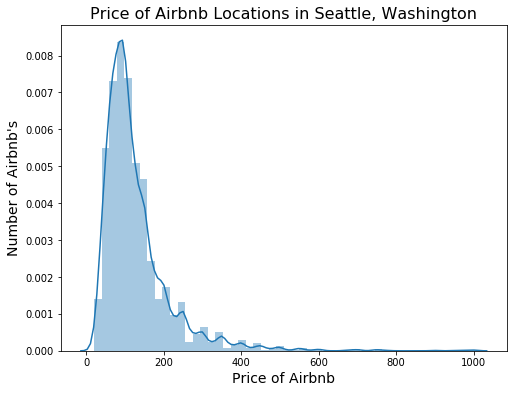

In [10]:
plt.figure(figsize=(8, 6))
# plt.hist(listings.price)
sns.distplot(listings.price)
plt.xlabel('Price of Airbnb', fontsize=14)
plt.ylabel("Number of Airbnb's", fontsize=14)
plt.title('Price of Airbnb Locations in Seattle, Washington', fontsize=16)
plt.show()

## Examine Ratings of Airbnb's

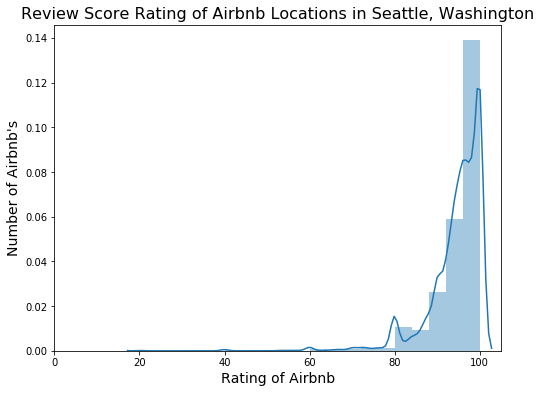

In [11]:
plt.figure(figsize=(8, 6))
sns.distplot(listings.review_scores_rating, bins=20)
plt.xlabel('Rating of Airbnb', fontsize=14)
plt.xlim(0, 105)
plt.ylabel("Number of Airbnb's", fontsize=14)
plt.title('Review Score Rating of Airbnb Locations in Seattle, Washington', fontsize=16)
plt.show()

In [12]:
listings.review_scores_rating.describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

In [13]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [14]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


In [15]:
marks = listings[['latitude', 'longitude', 'id', 'price', 'property_type', 'bedrooms', 'bathrooms']]
marks['property_type'] = marks['property_type'].replace({'Townhouse': 'Other', 
                                                         'Bungalow': 'Other',
                                                         'Condominium': 'Other', 
                                                         'Camper/RV': 'Other',
                                                         'Cabin': 'Other'})
marks.head()

,latitude,longitude,id,price,property_type,bedrooms,bathrooms
0,47.636289,-122.371025,241032,85.0,Apartment,1.0,1.0
1,47.639123,-122.365666,953595,150.0,Apartment,1.0,1.0
2,47.629724,-122.369483,3308979,975.0,House,5.0,4.5
3,47.638473,-122.369279,7421966,100.0,Apartment,0.0,1.0
4,47.632918,-122.372471,278830,450.0,House,3.0,2.0


In [16]:
locations = marks[['latitude', 'longitude']]
locationlist = locations.values.tolist()
print(len(locationlist))
locationlist[:5]

3818


[[47.636289038357184, -122.37102519997765],
 [47.63912312136253, -122.36566646439582],
 [47.629724131577355, -122.3694831756176],
 [47.63847320176642, -122.36927912263019],
 [47.63291840276724, -122.37247063402224]]

In [17]:
marks.loc[1]

latitude           47.6391
longitude         -122.366
id                  953595
price                  150
property_type    Apartment
bedrooms                 1
bathrooms                1
Name: 1, dtype: object

## Plot and Save Folium Maps with Locations of Airbnb Rentals

In [18]:
clusters= folium.Map(location=[47.6062, -122.3321],
                    zoom_start = 11)
plugins.MarkerCluster(locationlist).add_to(clusters)
plugins.ScrollZoomToggler().add_to(clusters)
clusters.save(os.path.join('Maps/', 'airbnb_cluster1.html'))
#clusters

In [19]:
airbnb_map=folium.Map(location=[listings.latitude.mean(),listings.longitude.mean()],
                      zoom_start=11,tiles='OpenStreetMap')
for point in np.random.randint(0, len(locationlist), 100):
    folium.Marker(locationlist[point]).add_to(airbnb_map)
plugins.ScrollZoomToggler().add_to(airbnb_map)
airbnb_map.save(os.path.join('Maps/', 'airbnb_ind_1.html'))
#airbnb_map

In [20]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_name,host_total_listings_count,street,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,Maija,3.0,"Gilman Dr W, Seattle, WA 98119, United States",...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",Andrea,6.0,"7th Avenue West, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,Jill,2.0,"West Lee Street, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [21]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [22]:
reviews_list = listings[['id', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

In [23]:
reviews_list.head()

,id,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,241032,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,953595,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3308979,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,7421966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,278830,92.0,9.0,9.0,10.0,10.0,9.0,9.0


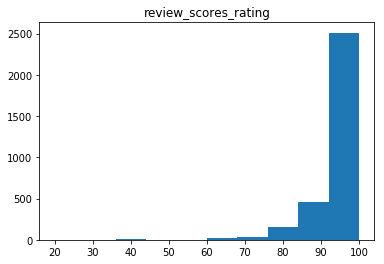

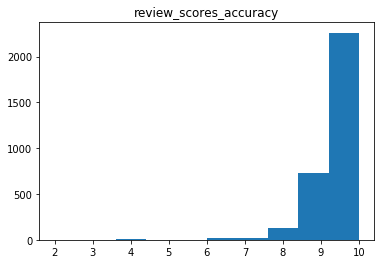

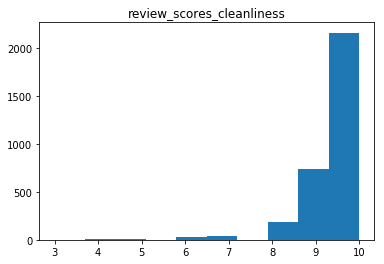

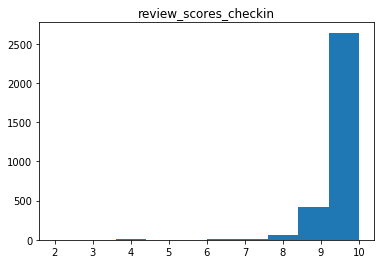

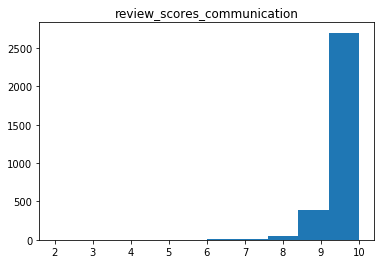

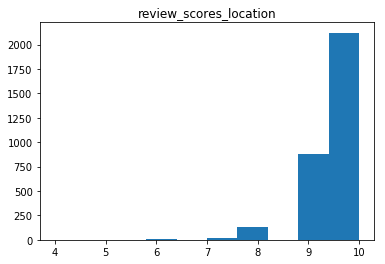

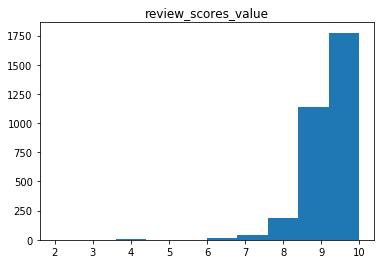

In [24]:
cols = reviews_list.columns[1:]
for col in cols:
    plt.figure()
    plt.hist(reviews_list[col].values)
    plt.title(str(col))

In [25]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [26]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         934542 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB


In [27]:
calendar['available'].replace({'t': True, 'f': False}, inplace=True)

In [28]:
calendar.fillna('$0.0', inplace=True)

In [29]:
calendar['price'] = calendar['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)

In [30]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,0.0
3,241032,2016-01-07,False,0.0
4,241032,2016-01-08,False,0.0


In [31]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
price         1393570 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 33.2 MB


In [32]:
calendar.sort_values(by='date', inplace=True)

In [33]:
calendar['available'].value_counts()

True     934542
False    459028
Name: available, dtype: int64

In [34]:
calendar.date.describe()

count                 1393570
unique                    365
top       2016-12-27 00:00:00
freq                     3818
first     2016-01-04 00:00:00
last      2017-01-02 00:00:00
Name: date, dtype: object

## Taking a Look at Availability of Rentals Over Time to Find any Seasonality

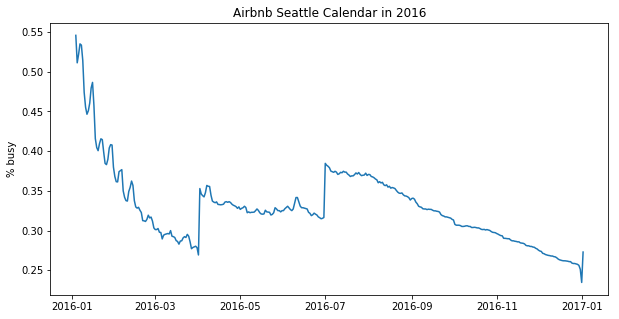

In [35]:
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map(lambda x: 0 if x == True else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Seattle Calendar in 2016')
plt.ylabel('% busy')
plt.show();

In [36]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null bool
price         1393570 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 43.9 MB


In [37]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [38]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_name,host_total_listings_count,street,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,Maija,3.0,"Gilman Dr W, Seattle, WA 98119, United States",...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",Andrea,6.0,"7th Avenue West, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,Jill,2.0,"West Lee Street, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [39]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB


# Analyze Text Data from Listings and Reviews

In [40]:
listings.head(3)

,id,name,summary,space,description,experiences_offered,transit,host_name,host_total_listings_count,street,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,Maija,3.0,"Gilman Dr W, Seattle, WA 98119, United States",...,10.0,9.0,10.0,f,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Convenient bus stops are just down the block, ...",Andrea,6.0,"7th Avenue West, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,A bus stop is just 2 blocks away. Easy bus a...,Jill,2.0,"West Lee Street, Seattle, WA 98119, United States",...,10.0,10.0,10.0,f,f,strict,f,f,2,1.15


In [41]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [42]:
listings_text = listings[['name', 'summary', 'space', 'description', 'transit', 'amenities']]

In [43]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [44]:
reviews.rename(index=str, columns={"id": "review_id"}, inplace=True)

In [45]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
review_id        84849 non-null int64
date             84849 non-null datetime64[ns]
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB


In [46]:
reviews.listing_id.nunique()

3191

In [47]:
reviews.dropna(inplace=True)

In [48]:
ids = list(reviews.listing_id.unique())

In [49]:
review_dict = {}
for i in ids:
    df = reviews.loc[reviews['listing_id'] == i]
    review_dict[i] = {}
    review_dict[i]['reviewer_id'] = (df['reviewer_id'])
    review_dict[i]['reviewer'] = (df['reviewer_name'])
    review_dict[i]['comments'] = (df['comments'])

In [50]:
reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [51]:
reviews.fillna('', inplace=True)

In [52]:
reviews.isna().sum()

listing_id       0
review_id        0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [53]:
reviews_text = list(reviews.comments)
all(type(r)==str for r in reviews_text)
for r in reviews_text:
    if type(r) == str:
        continue
    else:
        print(r)
        print(type(r))
        print("-"*50)
        print("\n")

In [54]:
all(type(r)==str for r in reviews_text)

True

## Tokenize Text of Reviews in Order to then run Sentiment Analysis

In [55]:
reviews_text

['Cute and cozy place. Perfect location to everything! ',
 'Kelly has a great room in a very central location. \r\nBeautiful building , architecture and a style that we really like. \r\nWe felt guite at home here and wish we had spent more time.\r\nWent for a walk and found Seattle Center with a major food festival in progress. What a treat.\r\nVisited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW.  Thanks for a great stay.',
 'Very spacious apartment, and in a great neighborhood.  This is the kind of apartment I wish I had!\r\n\r\nDidn\'t really get to meet Kelly until I was on my out, but she was always readily available by phone. \r\n\r\nI believe the only "issue" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday',
 "Close to Seattle Center and all it has to offer - ballet, theater, museum, Space Needle, restaurants of all ilk just blocks away, and the

In [56]:
start = timer()
tokens = reviews['comments'].apply(word_tokenize)
end = timer()
print(abs(end - start), "seconds elapsed")
%notify

51.846502075000004 seconds elapsed


<IPython.core.display.Javascript object>

In [57]:
tokens

0        [Cute, and, cozy, place, ., Perfect, location,...
1        [Kelly, has, a, great, room, in, a, very, cent...
2        [Very, spacious, apartment, ,, and, in, a, gre...
3        [Close, to, Seattle, Center, and, all, it, has...
4        [Kelly, was, a, great, host, and, very, accomm...
5        [Kelly, was, great, ,, place, was, great, ,, j...
6        [Kelly, was, great, !, Very, nice, and, the, n...
7        [hola, all, bnb, erz, -, Just, left, Seattle, ...
8        [Kelly, 's, place, is, conveniently, located, ...
9        [The, place, was, really, nice, ,, clean, ,, a...
10       [The, place, was, really, nice, ,, clean, and,...
11       [The, listing, was, exactly, as, described, !,...
12       [Very, welcoming, and, a, nicer, place, to, li...
13       [Great, location, ,, great, price, ,, great, h...
14       [Staying, at, Kelly, 's, was, easy, ., The, lo...
15       [Kelly, was, an, amazing, host, who, made, the...
16       [Despite, our, late, booking, request, ,, Rach.

# Sentiment Intensity Analysis of Reiews

In [58]:
# Run a test of the Vader Polarity Compound on two sample sentences
test_1 = 'Room was nice. Room was not awful at all. I really liked it.'
test_2 = 'I detest this room. It was terrible. I will not stay there any longer.'

vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']
vader_polarity_compound(test_1), vader_polarity_compound(test_2)

(0.8112, -0.4767)

In [59]:
print(reviews.comments.isnull().sum())
reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)
reviews.comments.isnull().sum()

0


0

In [60]:
if not os.path.exists('seattle_reviews.h5'):
    reviews['polarity'] = reviews.comments.map(vader_polarity_compound)
    reviews.to_hdf('seattle_reviews.h5', key='seattle_reviews', mode='w')

In [61]:
seattle_reviews = pd.read_hdf('seattle_reviews.h5', 'seattle_reviews')

In [62]:
seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783


In [63]:
seattle_reviews.polarity.describe()

count    84831.000000
mean         0.884985
std          0.221284
min         -0.997500
25%          0.898250
50%          0.954100
75%          0.977400
max          0.999700
Name: polarity, dtype: float64

In [64]:
seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783


## Graph the Average Sentiment Over Time to Look for any Time-Based Trends

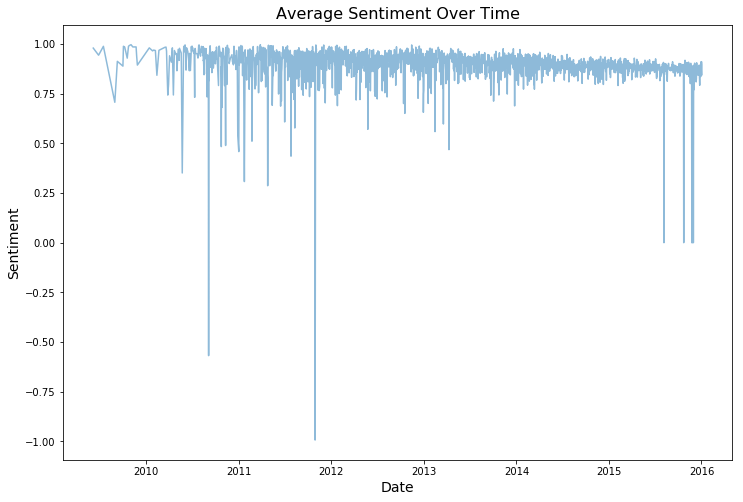

In [65]:
plt.figure(figsize=(12, 8))
plt.plot(seattle_reviews.groupby(by='date')['polarity'].mean(), alpha=0.5)
plt.title('Average Sentiment Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.show()

In [66]:
sort_seattle_reviews = seattle_reviews.sort_values(by='polarity')
sort_seattle_reviews.reset_index(drop=True, inplace=True)

## Sort through rows to find different polarity dispersions

In [67]:
sort_seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,258571,37845285,2015-07-11,31512581,Ysett,Wir sind 5 Nächte geblieben. Und es ist eine A...,-0.9975
1,1018204,5122651,2013-06-13,6775393,Heidi,"leider war esnicht so fein, da die unterkunft ...",-0.9970
2,4577542,44747593,2015-08-29,25805389,Sebastian,"Die Unterkunft war sehr schön und genau so, wi...",-0.9961
3,3291777,14760768,2014-06-25,16881604,Annar,Melissa replied to our request and approved bu...,-0.9956
4,1775016,21243349,2014-10-13,20072109,Anna,Staying at Robert’s place was a nightmare. At ...,-0.9941


In [68]:
sort_seattle_reviews.tail()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
84826,1048798,18062943,2014-08-21,5244721,Barb,If you are looking for a fabulous place to sta...,0.9994
84827,585418,30257274,2015-04-19,26386980,Victor,"Angela TOTALLY lived up to her ""reputation"" in...",0.9995
84828,5272327,50488125,2015-10-12,363242,Mika,This was such a great trip and experience!\r\n...,0.9995
84829,1048798,41201991,2015-08-05,31934586,Sandy,This was our third trip to Seattle to visit ou...,0.9995
84830,4429898,23827888,2014-12-11,13997957,Aindrea,Awesome location about a mile from downtown Ba...,0.9997


In [69]:
negative = sort_seattle_reviews[:849]
negative.tail()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
844,254340,14390095,2014-06-18,1400390,June,I have stayed here several times and each time...,-0.0102
845,5021969,48469891,2015-09-26,36582242,Arturo,"Experience was Good overall, the building is o...",-0.0096
846,5078244,30113047,2015-04-17,1503536,Tjark,Alberto was a very nice and helpful host. The ...,-0.0056
847,1198884,44676482,2015-08-28,39880231,Tommy,Very nice place. Really close to the conventio...,-0.0031
848,1097520,17511822,2014-08-13,58602,Julia,very nice place. a few things that went wrong...,-0.0018


In [70]:
sort_seattle_reviews[7998:8008]

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
7998,279063,36069664,2015-06-24,33500132,Jenny,Very good staying here. Quiet and convenient. ...,0.7496
7999,5261239,53944294,2015-11-14,20971142,Meghann,Was very easy to access the apartment. Very go...,0.7496
8000,1171574,29509679,2015-04-08,2772734,Shane,I loved staying here! Phil was so accommodatin...,0.7497
8001,3424991,42392677,2015-08-13,31991777,Seth,Great location and good price. I never met Mi...,0.7497
8002,1450262,37939534,2015-07-12,11106271,Eric,"My family and I stayed at Sarah's house twice,...",0.7498
8003,47196,231120,2011-04-18,506322,Timothy,Faye & I found Shalini & Eric's ground floor s...,0.7500
8004,7710713,47839279,2015-09-21,43814436,Francis,Everything was perfect and we felt welcomed in...,0.7500
8005,6482409,45670933,2015-09-05,36678106,Jim,Made the reservation after reading other revie...,0.7500
8006,2263643,50999663,2015-10-16,6791976,Marius,"Tessa is a wonderful host, I felt welcomed and...",0.7500
8007,2686374,54863290,2015-11-25,6287817,Stephan,I had a group of 4 people stay here for a long...,0.7500


In [71]:
sub_pt75 = sort_seattle_reviews[:8003]
top_pt75 = sort_seattle_reviews[8003:]

## All Reviews Graphically

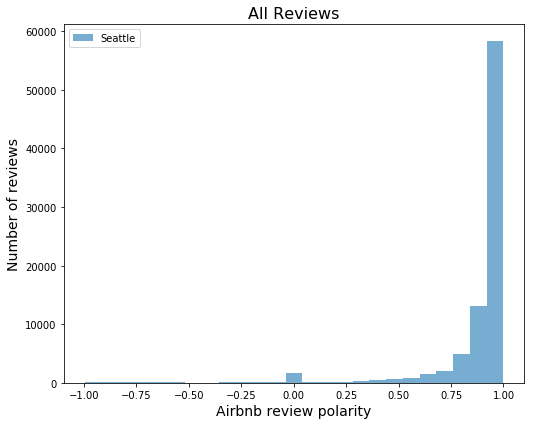

In [72]:
plt.figure(figsize=(8,6))
plt.hist(seattle_reviews.polarity, bins=25, alpha=0.6)
plt.legend(['Seattle'])
plt.xlabel('Airbnb review polarity', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
plt.title('All Reviews', fontsize=16)
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

Text(0.5, 1.0, 'All Reviews')

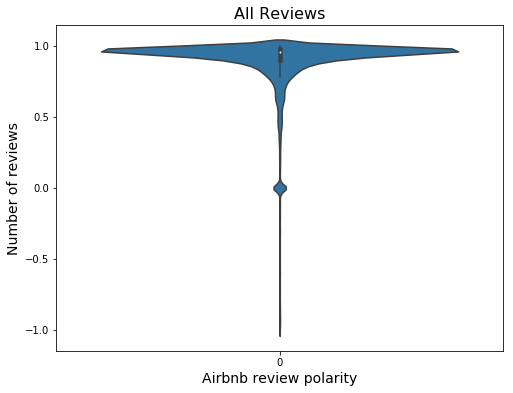

In [73]:
plt.figure(figsize=(8, 6))
sns.violinplot(data = seattle_reviews.polarity, label='Seattle')
plt.xlabel('Airbnb review polarity', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
plt.title('All Reviews', fontsize=16)

## All Reviews with Negative Sentiment

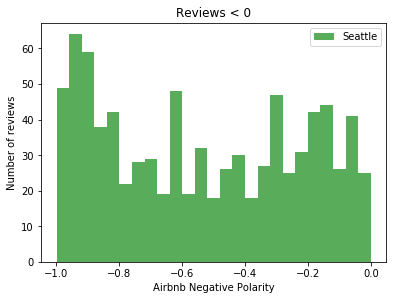

In [74]:
plt.hist(negative.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Negative Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews < 0')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

## All Reviews with Sentiment < 0.75

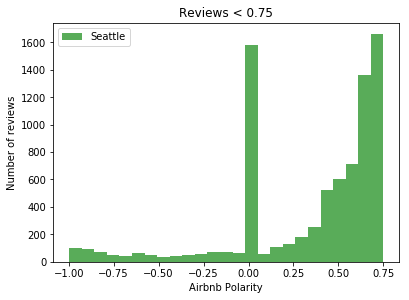

In [75]:
plt.hist(sub_pt75.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews < 0.75')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

## All Reviews with Sentiment >= 0.75

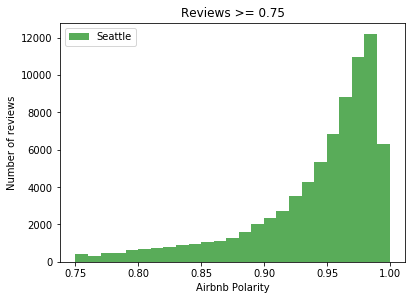

In [76]:
plt.hist(top_pt75.polarity, bins=25, color='g', alpha=0.65)
plt.legend(['Seattle'])
plt.xlabel('Airbnb Polarity')
plt.ylabel('Number of reviews')
plt.title('Reviews >= 0.75')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

# Now Need to Find Which Locations Received Poor Reviews

In [77]:
print("Number of Negatively Reviewed Air BnB Locations:", negative.listing_id.nunique())
# Create list of 'IDs' for Negative Reviews
negative_locs = list(negative.listing_id.unique())

Number of Negatively Reviewed Air BnB Locations: 559


In [78]:
print("Number of Locations Reviewed <0.75:", sub_pt75.listing_id.nunique())
sub_75_locs = list(sub_pt75.listing_id.unique())

Number of Locations Reviewed <0.75: 2037


In [79]:
print("Number of Locations Reviewed >0.75:", top_pt75.listing_id.nunique())
top_75_locs = list(top_pt75.listing_id.unique())

Number of Locations Reviewed >0.75: 3134


In [80]:
print("Total Number of Locations:", seattle_reviews.listing_id.nunique())
all_locs = list(seattle_reviews.listing_id.unique())

Total Number of Locations: 3191


In [81]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [82]:
negs = listings[['id', 'latitude', 'longitude']]
neg_ids = negative_locs
neg_dict = {}
for neg in neg_ids:
    df = negs.loc[negs['id'] == neg]
    neg_dict[neg] = {}
    neg_dict[neg]['lat'] = (df['latitude'])
    neg_dict[neg]['long'] = (df['longitude'])

In [83]:
lists_map = listings[['id', 'host_name', 'latitude', 'longitude', 'price', 'review_scores_rating', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                      'review_scores_location', 'review_scores_value']]
lists_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 12 columns):
id                             3818 non-null int64
host_name                      3816 non-null object
latitude                       3818 non-null float64
longitude                      3818 non-null float64
price                          3818 non-null float64
review_scores_rating           3171 non-null float64
review_scores_accuracy         3160 non-null float64
review_scores_cleanliness      3165 non-null float64
review_scores_checkin          3160 non-null float64
review_scores_communication    3167 non-null float64
review_scores_location         3163 non-null float64
review_scores_value            3162 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 358.0+ KB


In [84]:
seattle_reviews.head()

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783


In [85]:
seattle_reviews.rename(columns={"id": "review_id", "listing_id": "id"}, inplace=True)

In [86]:
seattle_reviews.head(20)

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783
5,7202016,43979139,2015-08-23,1154501,Barent,"Kelly was great, place was great, just what I ...",0.9349
6,7202016,45265631,2015-09-01,37853266,Kevin,Kelly was great! Very nice and the neighborhoo...,0.9421
7,7202016,46749120,2015-09-13,24445447,Rick,hola all bnb erz - Just left Seattle where I h...,0.9671
8,7202016,47783346,2015-09-21,249583,Todd,Kelly's place is conveniently located on a qui...,0.5562
9,7202016,48388999,2015-09-26,38110731,Tatiana,"The place was really nice, clean, and the most...",0.8613


In [87]:
lists_map.head()

,id,host_name,latitude,longitude,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,241032,Maija,47.636289,-122.371025,85.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,953595,Andrea,47.639123,-122.365666,150.0,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3308979,Jill,47.629724,-122.369483,975.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,7421966,Emily,47.638473,-122.369279,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,278830,Emily,47.632918,-122.372471,450.0,92.0,9.0,9.0,10.0,10.0,9.0,9.0


In [88]:
seattle_reviews['latitude'] = np.zeros(len(seattle_reviews))
seattle_reviews['longitude'] = np.zeros(len(seattle_reviews))
seattle_reviews['price'] = np.zeros(len(seattle_reviews))
seattle_reviews['rating'] = np.zeros(len(seattle_reviews))

In [89]:
seattle_reviews.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price,rating
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,0.0,0.0,0.0,0.0
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,0.0,0.0,0.0,0.0
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,0.0,0.0,0.0,0.0
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,0.0,0.0,0.0,0.0
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,0.0,0.0,0.0,0.0


In [90]:
lists_map.head()

,id,host_name,latitude,longitude,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,241032,Maija,47.636289,-122.371025,85.0,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,953595,Andrea,47.639123,-122.365666,150.0,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3308979,Jill,47.629724,-122.369483,975.0,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,7421966,Emily,47.638473,-122.369279,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,278830,Emily,47.632918,-122.372471,450.0,92.0,9.0,9.0,10.0,10.0,9.0,9.0


## Add to Seattle Reviews Table

- Add columns for Latitude, Longitude, Price, and Review Scores Rating from the Listings Table
- Using this information, we will be able to plot locations of certain polarity scores, as well as see how the polarity scores match with the review score ratings of each location
- Also creating an extra column called "score" which will be the product of the sentiment polarity from the review, and the review score rating

In [91]:
if not os.path.exists('seattle_reviews2.h5'):
    count = 0
    start = timer()
    current = timer()
    latitude = []
    longitude = []
    price = []
    reviews = []
    start = timer()
    for i in range(len(seattle_reviews)):
        df = seattle_reviews.iloc[i]
        index = df['id']
        latitude.append(float(lists_map[lists_map['id'] == index]['latitude'].values))
        longitude.append(float(lists_map[lists_map['id'] == index]['longitude'].values))
        price.append(float(lists_map[lists_map['id'] == index]['price'].values))
        reviews.append(float(lists_map[lists_map['id'] == index]['review_scores_rating'].values))
        count += 1
        if count % 500 == 0:
            print("Step {} / 169".format(int(count/500)))
            step = count/500
            current = timer()
            elapsed = round(current - start, 3)
            average = elapsed / step
            remaining = round((average*(169 - count/500)/60), 3)
            if elapsed < 60:
                print("Time elapsed: {} seconds".format(elapsed))
                print("Time remaining: {} minutes".format(remaining))
            else:
                print("Time elapsed: {} minutes".format(round(elapsed/60, 3)))
                print("Time remaining: {} minutes".format(remaining))
            print()
    seattle_reviews['latitude'] = latitude
    seattle_reviews['longitude'] = longitude
    seattle_reviews['price'] = price
    seattle_reviews['rating'] = reviews
    seattle_reviews['score'] = round((seattle_reviews['polarity'] * seattle_reviews['rating']), 2)
    seattle_reviews.fillna(method='bfill', inplace=True)
    seattle_reviews.to_hdf('seattle_reviews2.h5', key='seattle_reviews2', mode='w')
%notify

<IPython.core.display.Javascript object>

In [92]:
seattle_reviews2 = pd.read_hdf('seattle_reviews2.h5', 'seattle_reviews2')
seattle_reviews2.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price,rating,score
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,47.62621,-122.360147,75.0,95.0,75.06
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,47.62621,-122.360147,75.0,95.0,93.78
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,47.62621,-122.360147,75.0,95.0,82.82
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,47.62621,-122.360147,75.0,95.0,78.97
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,47.62621,-122.360147,75.0,95.0,92.94


In [93]:
seattle_reviews2.isna().sum()

id               0
review_id        0
date             0
reviewer_id      0
reviewer_name    0
comments         0
polarity         0
latitude         0
longitude        0
price            0
rating           0
score            0
dtype: int64

## Rating Scores

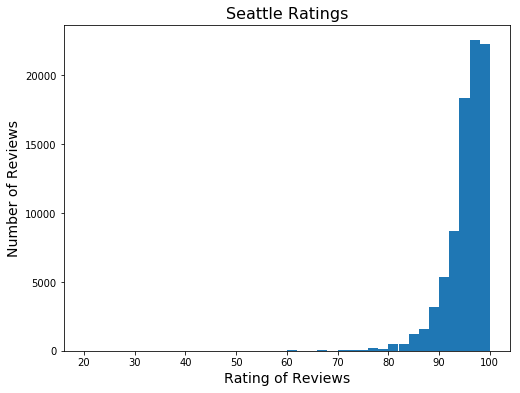

In [94]:
plt.figure(figsize=(8,6))
plt.hist(seattle_reviews2.rating, bins=40)
plt.title('Seattle Ratings', fontsize=16)
plt.xlabel('Rating of Reviews', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.show()

## Polarity Scores

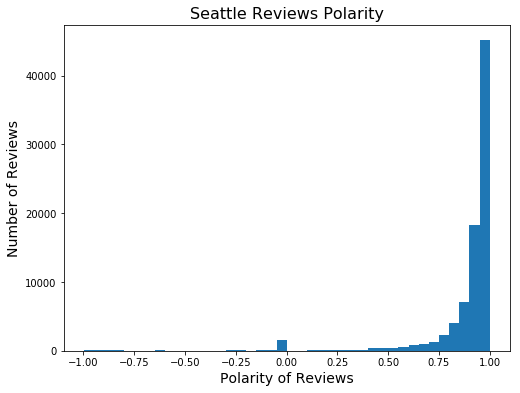

In [95]:
plt.figure(figsize=(8,6))
plt.hist(seattle_reviews2.polarity, bins=40)
plt.title('Seattle Reviews Polarity', fontsize=16)
plt.xlabel('Polarity of Reviews', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.show()

# Now that we have the Reviews' Polarity, Latitude, Longitude, and Price:
### Let's try and plot a Folium choropleth or heatmap showing good and bad reviews

## All Reviews with Sentiment = 0.0

In [96]:
neutral = seattle_reviews2[seattle_reviews2['polarity'] == 0]
neutral.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price,rating,score
80,7735100,43837578,2015-08-22,40603512,Puhong,我们是一家三口，可爱的女儿，夫妻二人都是中国来的访问学者，来到美丽的西雅图，住在了Roger...,0.0,47.652902,-122.352110,65.0,95.0,0.0
83,7735100,57419048,2015-12-25,13019539,Tibor,The host canceled this reservation 21 days bef...,0.0,47.652902,-122.352110,65.0,95.0,0.0
288,7550234,47535547,2015-09-20,40619236,Theo,Sehr gut,0.0,47.668715,-122.316316,40.0,94.0,0.0
291,7550234,49300785,2015-10-02,45425020,Dylan,The Blue room rocks!,0.0,47.668715,-122.316316,40.0,94.0,0.0
301,7550234,56949077,2015-12-20,47521443,Ying,房间的描述与实际相符，离华盛顿西雅图分校很近，非常完美，干净且安静，wifi很好，早餐也比较...,0.0,47.668715,-122.316316,40.0,94.0,0.0


In [97]:
# Ensure you're handing it floats
neutral['latitude'] = neutral['latitude'].astype(float)
neutral['longitude'] = neutral['longitude'].astype(float)
# Filter the DF for rows, then columns, then remove NaNs
neutral_df = neutral[['latitude', 'longitude']]
neutral_df = neutral_df.dropna(axis=0, subset=['latitude', 'longitude'])
# List comprehension to make out list of lists
neutral_data = [[row['latitude'], row['longitude']] for index, row in neutral_df.iterrows()]

In [98]:
# Ensure you're handing it floats
lists_map['latitude'] = lists_map['latitude'].astype(float)
lists_map['longitude'] = lists_map['longitude'].astype(float)
# Filter the DF for rows, then columns, then remove NaNs
heat_df = lists_map[['latitude', 'longitude']]
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])
# List comprehension to make out list of lists
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

In [99]:
# Ensure Seattle Reviews lat and long are floats
seattle_reviews2['latitude'] = seattle_reviews2['latitude'].astype(float)
seattle_reviews2['longitude'] = seattle_reviews2['longitude'].astype(float)
# Seattle reviews into heat_df1 and filter for NaNs
heat_df1 = seattle_reviews2[['latitude', 'longitude']]
heat_df1 = heat_df1.dropna(axis=0, subset=['latitude', 'longitude'])
#
heat_data1 = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

In [100]:
plus_75 = seattle_reviews2[seattle_reviews2['polarity'] > 0.75]

# Ensure Seattle Reviews lat and long are floats
plus_75['latitude'] = plus_75['latitude'].astype(float)
plus_75['longitude'] = plus_75['longitude'].astype(float)
# Seattle reviews into heat_df1 and filter for NaNs
plus_75df = plus_75[['latitude', 'longitude']]
plus_75df = plus_75df.dropna(axis=0, subset=['latitude', 'longitude'])
#
plus_75_data = [[row['latitude'],row['longitude']] for index, row in plus_75df.iterrows()]

In [101]:
sub_75 = seattle_reviews2[seattle_reviews2['polarity'] <= 0.75]

# Ensure Seattle Reviews lat and long are floats
sub_75['latitude'] = sub_75['latitude'].astype(float)
sub_75['longitude'] = sub_75['longitude'].astype(float)
# Seattle reviews into heat_df1 and filter for NaNs
sub_75df = sub_75[['latitude', 'longitude']]
sub_75df = sub_75df.dropna(axis=0, subset=['latitude', 'longitude'])
#
sub_75_data = [[row['latitude'],row['longitude']] for index, row in sub_75df.iterrows()]

In [102]:
neg_reviews = seattle_reviews2[seattle_reviews2['polarity'] < 0]

# Ensure Seattle Reviews lat and long are floats
neg_reviews['latitude'] = neg_reviews['latitude'].astype(float)
neg_reviews['longitude'] = neg_reviews['longitude'].astype(float)
# Seattle reviews into heat_df1 and filter for NaNs
neg_rev_df = neg_reviews[['latitude', 'longitude']]
neg_rev_df = neg_rev_df.dropna(axis=0, subset=['latitude', 'longitude'])
#
neg_rev_data = [[row['latitude'],row['longitude']] for index, row in neg_rev_df.iterrows()]

## HeatMap in Folium for Different Airbnb Locations...
### Layers in Map for Different Polarity of Reviews'

In [103]:
from folium import plugins
from folium.plugins import HeatMap


layer_heat_map = folium.Map(location=[47.6062, -122.3321],
                    zoom_start = 11, tiles='OpenStreetMap') 
folium.TileLayer(tiles="Stamen Terrain", name='Stamen Terrain').add_to(layer_heat_map)

# Plot it on the map
HeatMap(heat_data, min_opacity=0.7, radius=12, name='Locations in Seattle').add_to(layer_heat_map)
HeatMap(heat_data1, min_opacity=0.7, radius=12, name='Reviewed Locations in Seattle', 
        show=False).add_to(layer_heat_map)
HeatMap(plus_75_data, min_opacity=0.7, radius=12, name='Locations with Sentiment > 0.75',
        show=False).add_to(layer_heat_map)
HeatMap(sub_75_data, min_opacity=0.7, radius=12, name='Locations with Sentiment <= 0.75',
        show=False).add_to(layer_heat_map)
HeatMap(neg_rev_data, min_opacity=0.7, radius=12, name='Locations with Negative Sentiment',
        show=False).add_to(layer_heat_map)
HeatMap(neutral_data, min_opacity=0.7, radius=12, name='Locations with Neutral Sentiment',
        show=False).add_to(layer_heat_map)
layers = folium.LayerControl().add_to(layer_heat_map)
plugins.ScrollZoomToggler().add_to(layer_heat_map)

# Display the map
layer_heat_map.save('Maps/layer_heat_map.html')

## Re-Read in Data - Try to Build Machine Learning Classifier/Regressor to Predict Score

### Start with Seattle Reviews Data Set

## Import Libraries from SciKit-Learn

In [104]:
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.externals.six import StringIO
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score 
from sklearn.metrics import make_scorer, recall_score, roc_curve, precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

In [105]:
seattle_reviews2 = pd.read_hdf('seattle_reviews2.h5', 'seattle_reviews2')
seattle_reviews2.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price,rating,score
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,47.62621,-122.360147,75.0,95.0,75.06
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,47.62621,-122.360147,75.0,95.0,93.78
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,47.62621,-122.360147,75.0,95.0,82.82
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,47.62621,-122.360147,75.0,95.0,78.97
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,47.62621,-122.360147,75.0,95.0,92.94


In [106]:
seattle_reviews2.isna().sum()

id               0
review_id        0
date             0
reviewer_id      0
reviewer_name    0
comments         0
polarity         0
latitude         0
longitude        0
price            0
rating           0
score            0
dtype: int64

In [107]:
seattle_reviews2['score'].describe()

count    84831.000000
mean        84.155073
std         21.343773
min        -98.850000
25%         83.710000
50%         90.360000
75%         93.990000
max         99.930000
Name: score, dtype: float64

### Set Target Column as score (Rating * Polarity)
#### Score < 90      = 0
#### Score >= 90      = 1

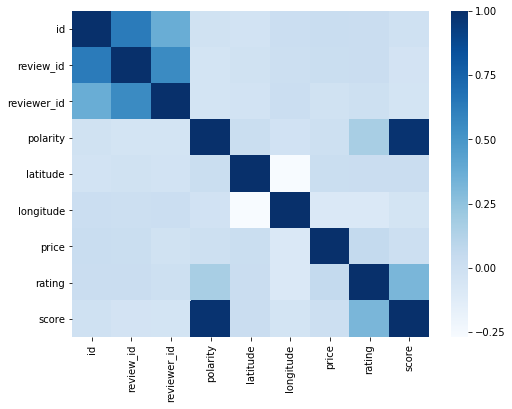

In [108]:
plt.figure(figsize=(8, 6))
sns.heatmap(seattle_reviews2.corr(), cmap='Blues')

In [109]:
df = seattle_reviews2
df['score'].values[df['score'] < 90] = int(0)
df['score'].values[df['score'] >= 90] = int(1)

In [110]:
df['score'].value_counts()

1.0    44150
0.0    40681
Name: score, dtype: int64

In [111]:
target = seattle_reviews2.score
features = seattle_reviews2.drop(columns='score')

In [112]:
features.drop(columns=['reviewer_name', 'comments', 'date', 'review_id'], inplace=True)
features = pd.get_dummies(features)
features.head()

,id,reviewer_id,polarity,latitude,longitude,price,rating
0,7202016,28943674,0.7901,47.62621,-122.360147,75.0,95.0
1,7202016,32440555,0.9872,47.62621,-122.360147,75.0,95.0
2,7202016,37722850,0.8718,47.62621,-122.360147,75.0,95.0
3,7202016,33671805,0.8313,47.62621,-122.360147,75.0,95.0
4,7202016,34959538,0.9783,47.62621,-122.360147,75.0,95.0


In [113]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [114]:
df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
df.head()

,id,reviewer_id,polarity,latitude,longitude,price,rating
0,1.697155,0.881305,-0.428795,-0.008335,-0.850296,-0.494971,0.025345
1,1.697155,1.139626,0.461921,-0.008335,-0.850296,-0.494971,0.025345
2,1.697155,1.529838,-0.059584,-0.008335,-0.850296,-0.494971,0.025345
3,1.697155,1.230580,-0.242608,-0.008335,-0.850296,-0.494971,0.025345
4,1.697155,1.325708,0.421701,-0.008335,-0.850296,-0.494971,0.025345


In [115]:
X = features
y = target
print(X.shape, y.shape)

(84831, 7) (84831,)


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

In [117]:
print(X_train.shape, X_test.shape)
print('-'*25)
print(y_train.shape, y_test.shape)

(63623, 7) (21208, 7)
-------------------------
(63623,) (21208,)


In [118]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=25)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=25,
            splitter='best')

In [119]:
y_preds = clf.predict(X_test)

In [120]:
accuracy_score(y_test, y_preds)

0.9996699358732554

In [121]:
recall_score(y_test, y_preds)

0.9996358007830283

In [122]:
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[10222     3]
 [    4 10979]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10225
         1.0       1.00      1.00      1.00     10983

   micro avg       1.00      1.00      1.00     21208
   macro avg       1.00      1.00      1.00     21208
weighted avg       1.00      1.00      1.00     21208



In [123]:
clf.feature_importances_

array([1.51392319e-04, 1.08984091e-04, 6.34747372e-01, 1.69572642e-04,
       0.00000000e+00, 6.31638815e-06, 3.64816363e-01])

In [124]:
def plot_feature_importances(model, figsize=(12,12)):
    
    """Visualize feature importance of selected model as determined by feature_importances_ method."""
    
    n_features = X_train.shape[1]
    plt.figure(figsize=figsize)
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature Importance", fontsize=14)
    plt.ylabel("Feature", fontsize=14)
    plt.title("Feature Importances", fontsize=14)

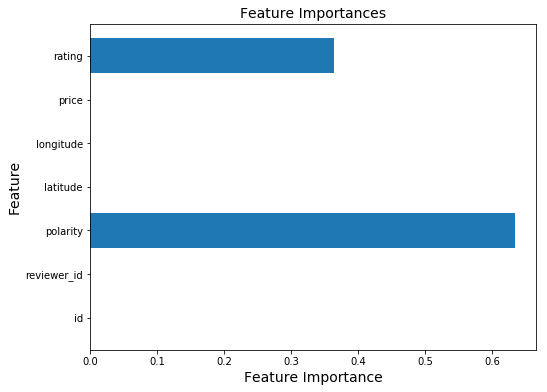

In [125]:
plot_feature_importances(clf, figsize=(8, 6))

## Not Surprisingly:
- 99.99% Accuracy, since our score was made up of the product of polarity and rating, there is an almost perfect accuracy from these two features
- Polarity had feature importance of 63.54%
- Rating had feature importance of 36.46

## Let's try differently.....
- What if we use the listings information, and add the score as a column on the listings dataframe as a target to try again....

In [126]:
listings = pd.read_csv('Data/seattle_airbnb/listings.csv')
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [127]:
listings.drop(columns=['license', 'notes', ])

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,9.0,10.0,f,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,10.0,f,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,10.0,f,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,NaN,f,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,9.0,f,WASHINGTON,f,strict,f,f,1,0.89
5,5956968,https://www.airbnb.com/rooms/5956968,20160104002432,2016-01-04,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,none,This part of Queen Anne has wonderful views an...,...,10.0,10.0,f,WASHINGTON,f,strict,f,f,1,2.45
6,1909058,https://www.airbnb.com/rooms/1909058,20160104002432,2016-01-04,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,none,"Close restaurants, coffee shops and grocery st...",...,10.0,10.0,f,WASHINGTON,f,moderate,f,f,1,2.46
7,856550,https://www.airbnb.com/rooms/856550,20160104002432,2016-01-04,Tiny Garden cabin on Queen Anne,"Our tiny cabin is private , very quiet and com...","This cabin was built with Airbnb in mind, Que...","Our tiny cabin is private , very quiet and com...",none,We are centrally located between Downtown and ...,...,9.0,10.0,f,WASHINGTON,f,strict,t,t,5,4.73
8,4948745,https://www.airbnb.com/rooms/4948745,20160104002432,2016-01-04,Urban Charm || Downtown || Views,"Nestled in the heart of the city, this space i...","Located in the heart of the city, this space i...","Nestled in the heart of the city, this space i...",none,Walking Score: 92 4 blocks from Kerry Park Fam...,...,10.0,10.0,f,WASHINGTON,f,strict,f,f,1,1.22
9,2493658,https://www.airbnb.com/rooms/2493658,20160104002432,2016-01-04,Airy + Bright Queen Anne Apartment,"Beautiful apartment in an extremely safe, quie...",What's special about this place? A beautiful r...,"Beautiful apartment in an extremely safe, quie...",none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,9.0,f,WASHINGTON,f,strict,t,t,6,1.55


In [128]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [129]:
worthless_info = listings[['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 
                           'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
                           'neighbourhood_group_cleansed', 'country_code', 'country', 'is_location_exact',
                           'calendar_last_scraped', 'license', 'jurisdiction_names', 'square_feet',
                           'notes', 'neighborhood_overview']]
host_info = listings[['host_id', 'host_url', 'host_since', 'host_location', 'host_about',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
                      'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count',
                      'host_verifications', 'host_has_profile_pic', 'host_identity_verified']]

In [130]:
drop = pd.concat([worthless_info, host_info], axis=1)
drop = drop.columns
drop

Index(['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'country_code', 'country',
       'is_location_exact', 'calendar_last_scraped', 'license',
       'jurisdiction_names', 'square_feet', 'notes', 'neighborhood_overview',
       'host_id', 'host_url', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified'],
      dtype='object')

In [131]:
listings = listings.drop(drop, axis=1)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 58 columns):
id                                  3818 non-null int64
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
transit                             2884 non-null object
host_name                           3816 non-null object
host_total_listings_count           3816 non-null float64
street                              3818 non-null object
neighbourhood                       3402 non-null object
city                                3818 non-null object
state                               3818 non-null object
zipcode                             3811 non-null object
market                              3818 non-null object
smart_location                      38

In [132]:
more_drops = ['space', 'transit', 'street', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 
              'first_review', 'last_review', 'summary', 'neighbourhood']
listings.drop(columns=more_drops, inplace=True)

In [133]:
print("Null Values in DataFrame: ", listings.isna().sum().sum())
print()
print("Backfill columns with most null values, then forwardfill the remaining null values")
listings['review_scores_accuracy'].fillna(method='backfill', inplace=True)
listings['review_scores_checkin'].fillna(method='backfill', inplace=True)
listings['review_scores_cleanliness'].fillna(method='backfill', inplace=True)
listings['review_scores_communication'].fillna(method='backfill', inplace=True)
listings['review_scores_location'].fillna(method='backfill', inplace=True)
listings['review_scores_rating'].fillna(method='backfill', inplace=True)
listings['review_scores_value'].fillna(method='backfill', inplace=True)
listings['reviews_per_month'].fillna(method='backfill', inplace=True)
listings.fillna(method='ffill', inplace=True)
print()
print("Remaining Null Values in DataFrame: ", listings.isna().sum().sum())

Null Values in DataFrame:  5240

Backfill columns with most null values, then forwardfill the remaining null values

Remaining Null Values in DataFrame:  0


In [134]:
listings['price'] = listings['price'].fillna('$0.00')
listings['price'] = listings['price'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('float')

In [135]:
extra_drops = ['name', 'description', 'experiences_offered', 'host_name', 'state', 'market', 'smart_location',
               'calendar_updated']
listings.drop(columns=extra_drops, inplace=True)

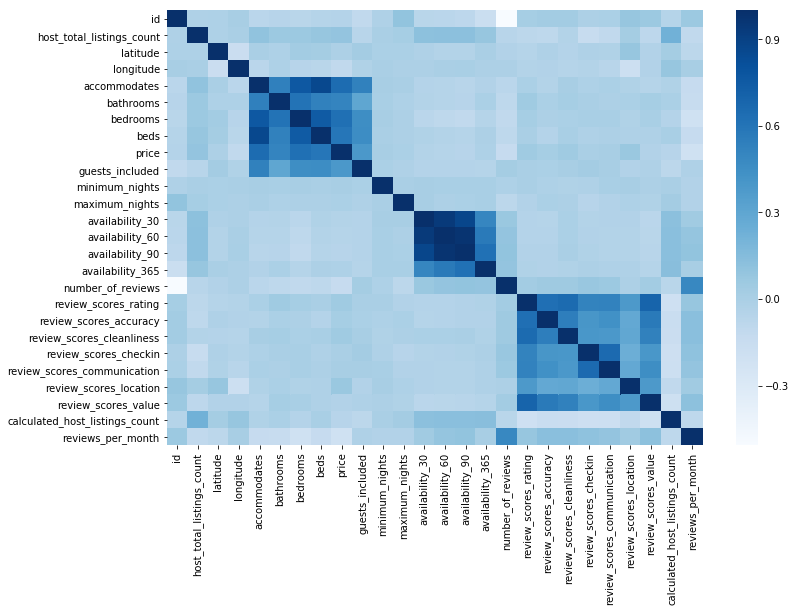

In [136]:
plt.figure(figsize=(12, 8))
sns.heatmap(listings.corr(), cmap='Blues')

In [137]:
tokenizer = RegexpTokenizer(r'\w+')
list_tokens = listings['amenities'].apply(tokenizer.tokenize)

In [138]:
listings['amenities'] = list_tokens

In [139]:
amenities_df = pd.get_dummies(listings['amenities'].apply(pd.Series).stack()).sum(level=0)

In [140]:
listings['has_availability'].replace({'t': True, 'f': False}, inplace=True)
listings['requires_license'].replace({'t': True, 'f': False}, inplace=True)
listings['instant_bookable'].replace({'t': True, 'f': False}, inplace=True)
listings['require_guest_phone_verification'].replace({'t': True, 'f': False}, inplace=True)
listings['require_guest_profile_picture'].replace({'t': True, 'f': False}, inplace=True)
listings['extra_people'] = listings['extra_people'].map(lambda x: False if x == '$0.00' else True)

In [141]:
listings.drop(columns='amenities', inplace=True)
listings = pd.get_dummies(listings)

In [142]:
listings = pd.concat([listings, amenities_df], axis=1)

In [143]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Columns: 164 entries, id to this
dtypes: bool(6), float64(85), int64(11), uint8(62)
memory usage: 3.1 MB


In [144]:
seattle_reviews2 = pd.read_hdf('seattle_reviews2.h5', 'seattle_reviews2')
seattle_reviews2.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price,rating,score
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,47.62621,-122.360147,75.0,95.0,75.06
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,47.62621,-122.360147,75.0,95.0,93.78
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,47.62621,-122.360147,75.0,95.0,82.82
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,47.62621,-122.360147,75.0,95.0,78.97
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,47.62621,-122.360147,75.0,95.0,92.94


In [145]:
listings['score'] = np.zeros(len(listings))

In [146]:
if not os.path.exists('listings_cumulative.h5'):
    scores = seattle_reviews2.groupby(by='id')['score'].mean()
    ids = list(listings.id.unique())
    seattle = list(seattle_reviews2.id.unique())
    count = 0
    non = 0
    start = timer()
    score_ids = []
    score_list = []
    for i in ids:
        count += 1
        if i in seattle:
            score_ids.append(i)
            score_list.append(scores[i])
        else:
    #         print(i, "is not reviewed")
            non += 1
            score_ids.append(i)
            score_list.append(0)

    #     if count % 15 == 0:
    #         current = timer()
    #         elapsed = round(abs(current - start), 3)
    #         step = count/15
    #         average = elapsed / step
    #         remaining = round((average*(254 - count/15)/60), 3)
    #         print("{} / {} rows complete".format(count, len(listings)))
    #         if elapsed < 60:
    #             print("Time elapsed: {} seconds".format(elapsed))
    #             print("Time remaining: {} minutes".format(remaining))
    #         else:
    #             print("Time elapsed: {} minutes".format(round(elapsed/60, 3)))
    #             print("Time remaining: {} minutes".format(remaining))
    #         print()
    print(non, "ids were note reviewed")
    listings.sort_values(by='id', inplace=True)
    listings['score'] = score_list
    listings.reset_index(drop=True, inplace=True)
    listings.fillna(method = 'bfill', inplace=True)
    
    listings.to_hdf('listings_cumulative.h5', key='listings_cumulative', mode='w')

### Set Target Column as score (Rating * Polarity)
#### Score < 85      = 0
#### Score >= 85      = 1

In [147]:
seattle_reviews2.score.describe()

count    84831.000000
mean        84.155073
std         21.343773
min        -98.850000
25%         83.710000
50%         90.360000
75%         93.990000
max         99.930000
Name: score, dtype: float64

In [148]:
df = pd.read_hdf('listings_cumulative.h5', key='listings_cumulative')
df.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,Workspace,for,in,live,on,pet,property,s,this,score
0,3335,4.0,47.529846,-122.275840,4,1.0,2.0,2.0,120.0,2,...,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,0.000000
1,4291,6.0,47.687251,-122.313130,2,1.0,1.0,1.0,82.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,71.317714
2,5682,1.0,47.523980,-122.359891,2,1.0,1.0,1.0,48.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,85.204831
3,6606,3.0,47.654109,-122.337605,2,1.0,1.0,1.0,90.0,2,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,85.020577
4,7369,1.0,47.615397,-122.325640,2,1.0,1.0,1.0,85.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,84.982250


In [149]:
drop = list(df.columns[32:-1])
corr = df.drop(columns=drop)
corr.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,score
0,3335,4.0,47.529846,-122.275840,4,1.0,2.0,2.0,120.0,2,...,9.0,9.0,9.0,False,False,False,False,4,0.80,0.000000
1,4291,6.0,47.687251,-122.313130,2,1.0,1.0,1.0,82.0,1,...,9.0,9.0,9.0,False,False,False,False,5,1.14,71.317714
2,5682,1.0,47.523980,-122.359891,2,1.0,1.0,1.0,48.0,1,...,10.0,9.0,10.0,False,True,False,True,1,4.21,85.204831
3,6606,3.0,47.654109,-122.337605,2,1.0,1.0,1.0,90.0,2,...,9.0,10.0,9.0,False,False,False,False,1,0.66,85.020577
4,7369,1.0,47.615397,-122.325640,2,1.0,1.0,1.0,85.0,1,...,10.0,10.0,9.0,False,False,False,False,1,0.50,84.982250


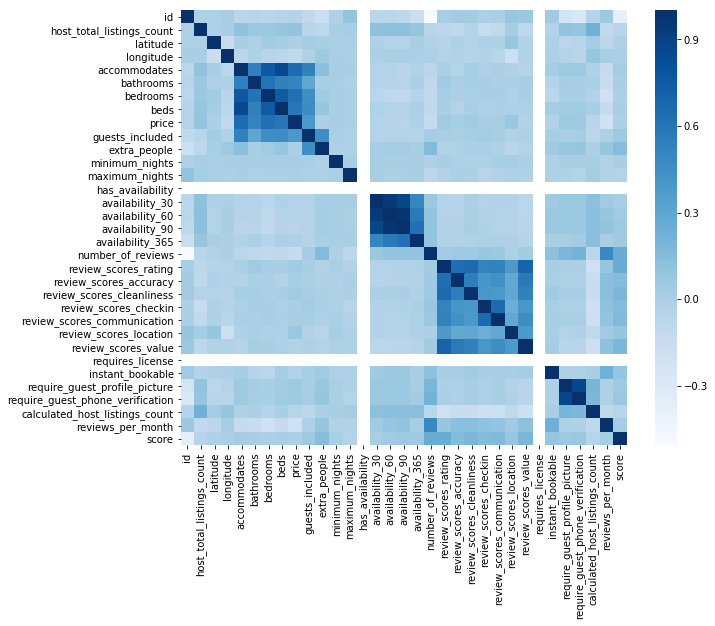

In [150]:
plt.figure(figsize=(10,8))
sns.heatmap(corr.corr(), cmap='Blues');

In [151]:
df['score'].describe()

count    3818.000000
mean       69.445612
std        33.149688
min       -40.920000
25%        68.905833
50%        83.807413
75%        90.391856
max        99.650000
Name: score, dtype: float64

In [152]:
df['score'].values[df['score'] < 85] = int(0)
df['score'].values[df['score'] >= 85] = int(1)

In [153]:
df['score'].value_counts()

0.0    2085
1.0    1733
Name: score, dtype: int64

In [154]:
target = df.score
features = df.drop(columns='score')

In [155]:
features.isna().sum().sum()

0

In [156]:
features.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,Wireless,Workspace,for,in,live,on,pet,property,s,this
0,3335,4.0,47.529846,-122.275840,4,1.0,2.0,2.0,120.0,2,...,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0
1,4291,6.0,47.687251,-122.313130,2,1.0,1.0,1.0,82.0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5682,1.0,47.523980,-122.359891,2,1.0,1.0,1.0,48.0,1,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6606,3.0,47.654109,-122.337605,2,1.0,1.0,1.0,90.0,2,...,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0
4,7369,1.0,47.615397,-122.325640,2,1.0,1.0,1.0,85.0,1,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [158]:
df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
df.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,Wireless,Workspace,for,in,live,on,pet,property,s,this
0,-1.872473,-0.110333,-2.302505,1.804132,0.329029,-0.438908,0.783554,0.231949,-0.088390,0.249756,...,-0.29697,-0.499345,-0.241862,-0.647474,1.804553,1.621879,8.594344,1.804553,3.396624,1.804553
1,-1.872151,-0.040445,1.354127,0.629263,-0.682431,-0.438908,-0.348773,-0.645733,-0.509498,-0.513098,...,-0.29697,-0.499345,-0.241862,-0.647474,-0.554154,0.226895,-0.116356,-0.554154,-0.487848,-0.554154
2,-1.871681,-0.215165,-2.438800,-0.843951,-0.682431,-0.438908,-0.348773,-0.645733,-0.886278,-0.513098,...,-0.29697,2.002623,-0.241862,1.088521,-0.554154,-1.168089,-0.116356,-0.554154,-0.487848,-0.554154
3,-1.871369,-0.145277,0.584203,-0.141838,-0.682431,-0.438908,-0.348773,-0.645733,-0.420844,0.249756,...,-0.29697,-0.499345,-0.241862,-0.647474,1.804553,1.621879,-0.116356,1.804553,1.454388,1.804553
4,-1.871112,-0.215165,-0.315090,0.235150,-0.682431,-0.438908,-0.348773,-0.645733,-0.476252,-0.513098,...,-0.29697,2.002623,-0.241862,1.088521,-0.554154,-1.168089,-0.116356,-0.554154,-0.487848,-0.554154


In [159]:
X = features
y = target
print(X.shape, y.shape)

(3818, 164) (3818,)


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

In [161]:
print(X_train.shape, X_test.shape)
print('-'*25)
print(y_train.shape, y_test.shape)

(2863, 164) (955, 164)
-------------------------
(2863,) (955,)


In [162]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=25)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=25,
            splitter='best')

In [163]:
y_preds1 = clf.predict(X_test)

In [164]:
accuracy_score(y_test, y_preds1)

0.7717277486910995

In [165]:
recall_score(y_test, y_preds1)

0.7348314606741573

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79       510
         1.0       0.77      0.73      0.75       445

   micro avg       0.77      0.77      0.77       955
   macro avg       0.77      0.77      0.77       955
weighted avg       0.77      0.77      0.77       955



Text(33.0, 0.5, 'Actual')

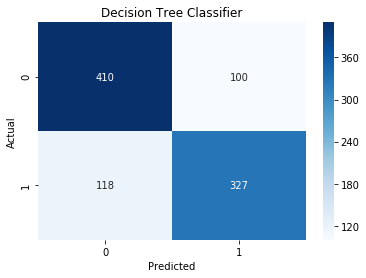

In [167]:
print(classification_report(y_test, y_preds1))
sns.heatmap(confusion_matrix(y_test, y_preds1), cmap='Blues', annot=True, fmt='0.16g')
plt.title('Decision Tree Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [168]:
def plot_feature_importances(model, figsize=(12,12)):
    
    """Visualize feature importance of selected model as determined by feature_importances_ method."""
    
    n_features = X_train.shape[1]
    plt.figure(figsize=figsize)
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")

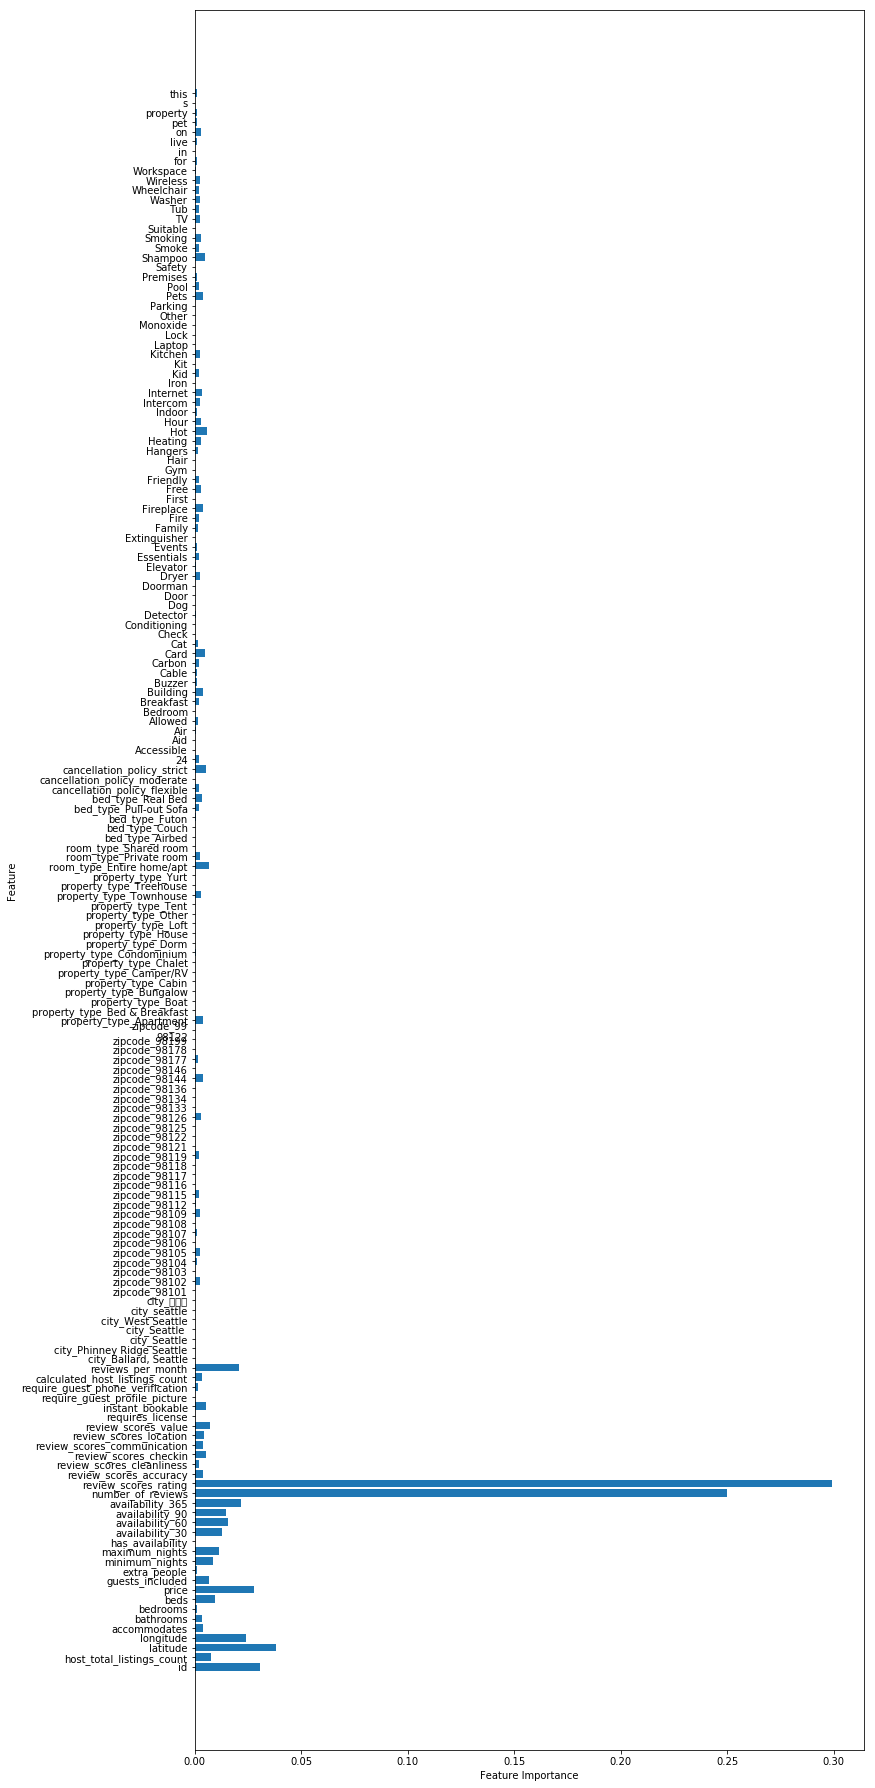

In [169]:
plot_feature_importances(clf, figsize=(12, 32))

Step 1 / 10
Step 2 / 10
Step 3 / 10
Step 4 / 10
Step 5 / 10
Step 6 / 10
Step 7 / 10
Step 8 / 10
Step 9 / 10
Step 10 / 10


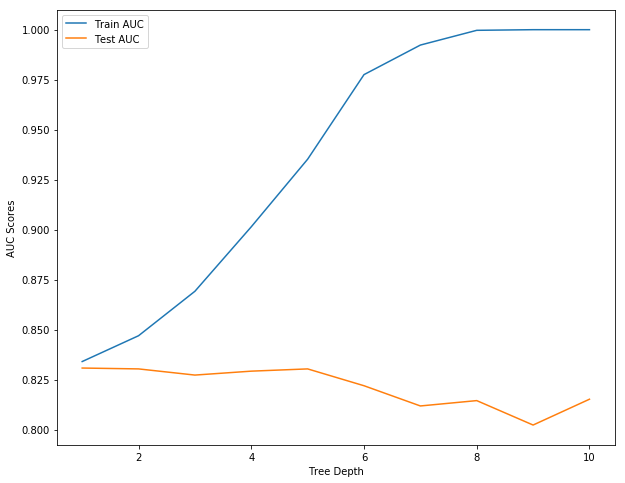

In [170]:
# Visualize effect of different max_depths on AUC scores

max_depths = np.linspace(1,10,10,endpoint=True)
train_auc = []
test_auc = []
count = 0
for depth in max_depths:
    
    clf = GradientBoostingClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = clf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)
    count += 1
    print("Step {} / {}".format(count, len(max_depths)))
plt.figure(figsize=(10,8))
plt.plot(max_depths, train_auc, label='Train AUC')
plt.plot(max_depths, test_auc, label='Test AUC')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

## Random Forest Classifier

In [171]:
rf_clf = RandomForestClassifier(random_state=25)

In [172]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [173]:
y_preds2 = rf_clf.predict(X_test)

In [174]:
accuracy_score(y_test, y_preds2)

0.7769633507853403

In [175]:
recall_score(y_test, y_preds2)

0.7325842696629213

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80       510
         1.0       0.78      0.73      0.75       445

   micro avg       0.78      0.78      0.78       955
   macro avg       0.78      0.77      0.77       955
weighted avg       0.78      0.78      0.78       955



Text(33.0, 0.5, 'Actual')

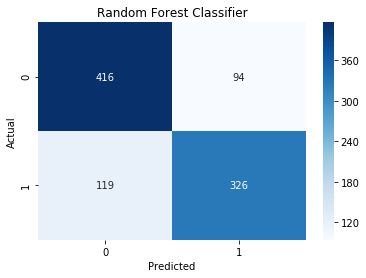

In [176]:
print(classification_report(y_test, y_preds2))
sns.heatmap(confusion_matrix(y_test, y_preds2), cmap='Blues', annot=True, fmt='0.16g')
plt.title('Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

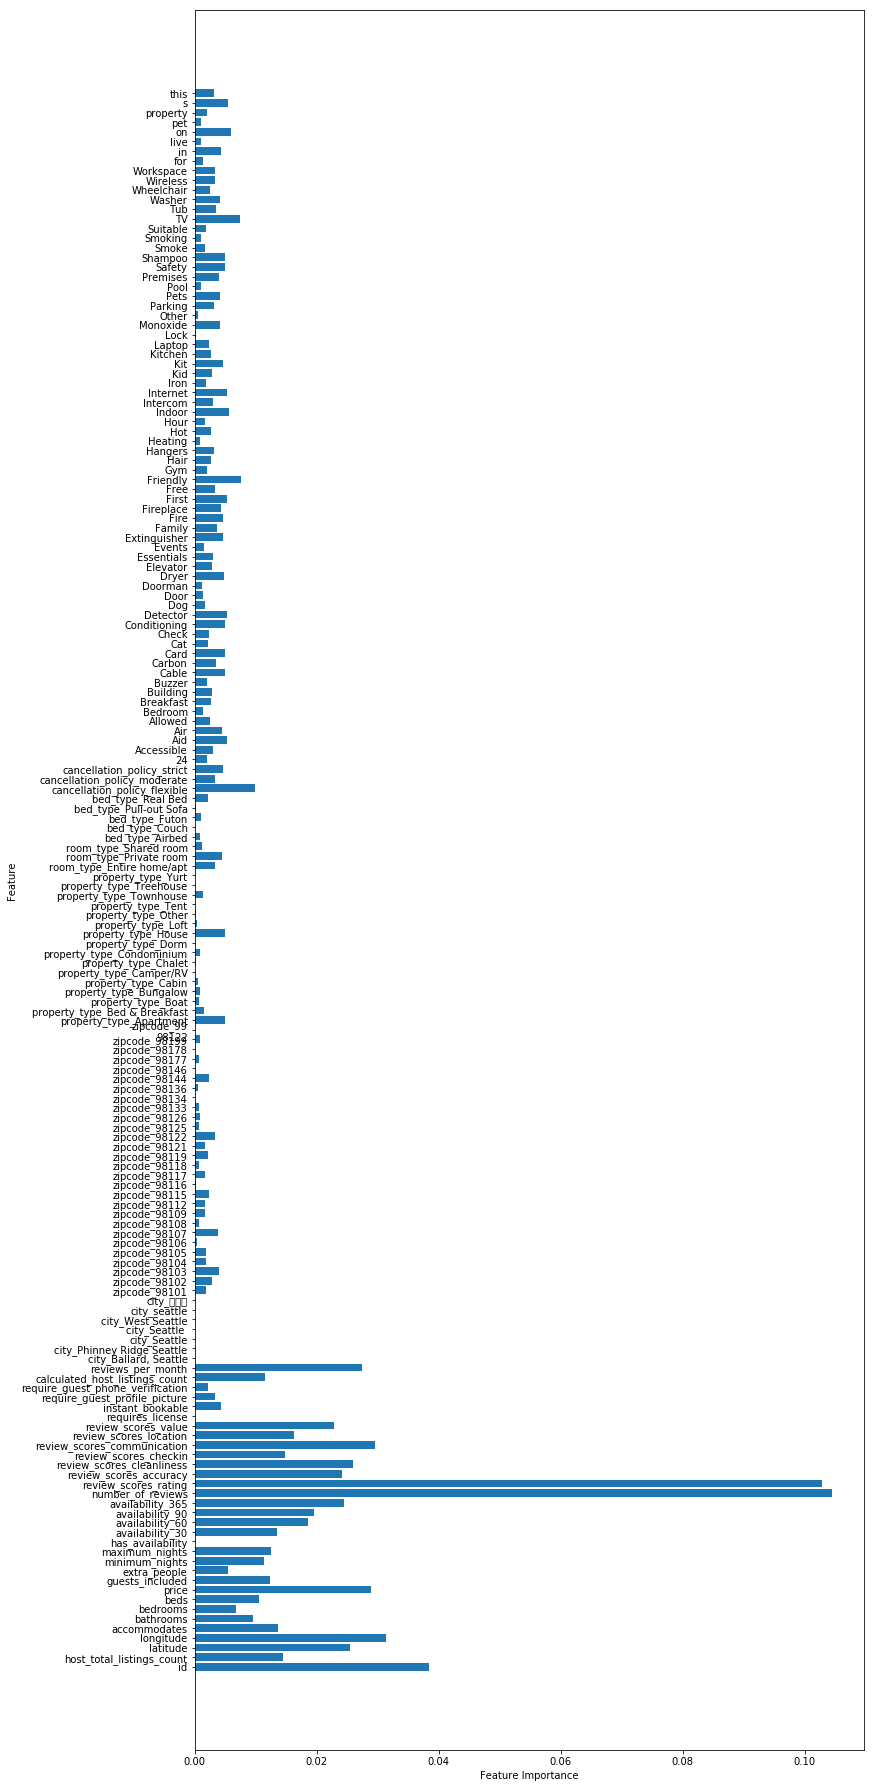

In [177]:
plot_feature_importances(rf_clf, figsize=(12, 32))

Step 1 / 10
Step 2 / 10
Step 3 / 10
Step 4 / 10
Step 5 / 10
Step 6 / 10
Step 7 / 10
Step 8 / 10
Step 9 / 10
Step 10 / 10


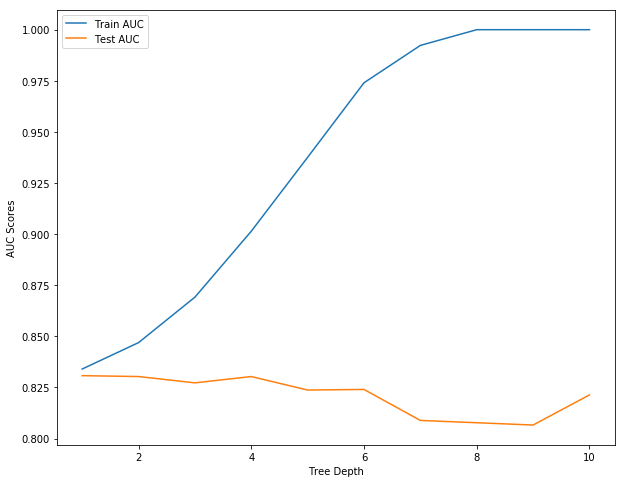

In [178]:
# Visualize effect of different max_depths on AUC scores

max_depths = np.linspace(1,10,10,endpoint=True)
train_auc = []
test_auc = []
count = 0
for depth in max_depths:
    
    clf = GradientBoostingClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = clf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)
    count += 1
    print("Step {} / {}".format(count, len(max_depths)))
plt.figure(figsize=(10,8))
plt.plot(max_depths, train_auc, label='Train AUC')
plt.plot(max_depths, test_auc, label='Test AUC')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

## Adaboost Classifier

In [179]:
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [180]:
y_preds3 = ada_clf.predict(X_test)

In [181]:
accuracy_score(y_test, y_preds3)

0.8219895287958116

In [182]:
recall_score(y_test, y_preds3)

0.8764044943820225

              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82       510
         1.0       0.77      0.88      0.82       445

   micro avg       0.82      0.82      0.82       955
   macro avg       0.83      0.83      0.82       955
weighted avg       0.83      0.82      0.82       955



Text(33.0, 0.5, 'Actual')

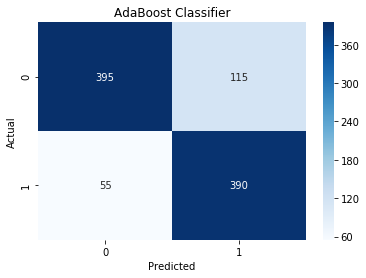

In [183]:
print(classification_report(y_test, y_preds3))
sns.heatmap(confusion_matrix(y_test, y_preds3), cmap='Blues', fmt='0.16g', annot=True)
plt.title('AdaBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

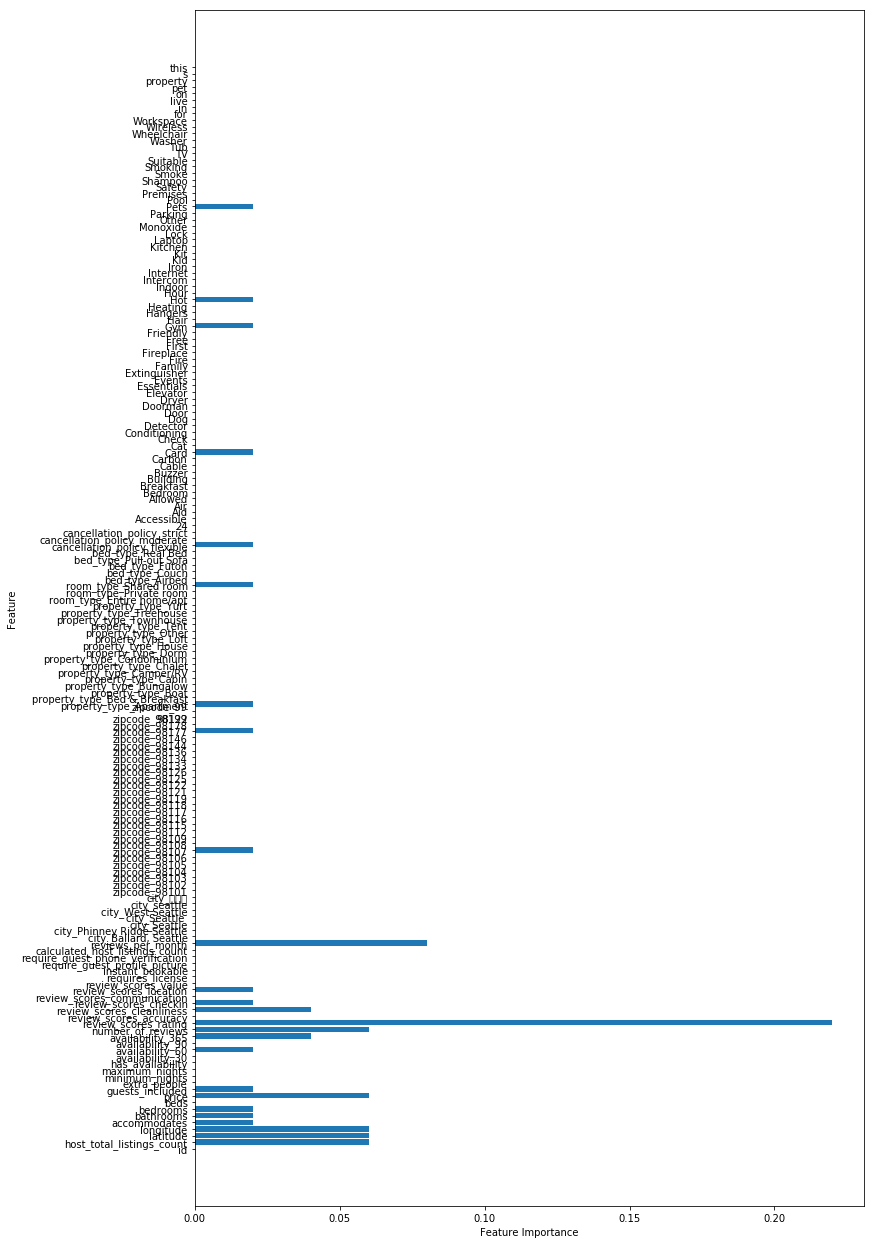

In [184]:
plot_feature_importances(ada_clf, figsize=(12, 22))

Step 1 / 10
Step 2 / 10
Step 3 / 10
Step 4 / 10
Step 5 / 10
Step 6 / 10
Step 7 / 10
Step 8 / 10
Step 9 / 10
Step 10 / 10


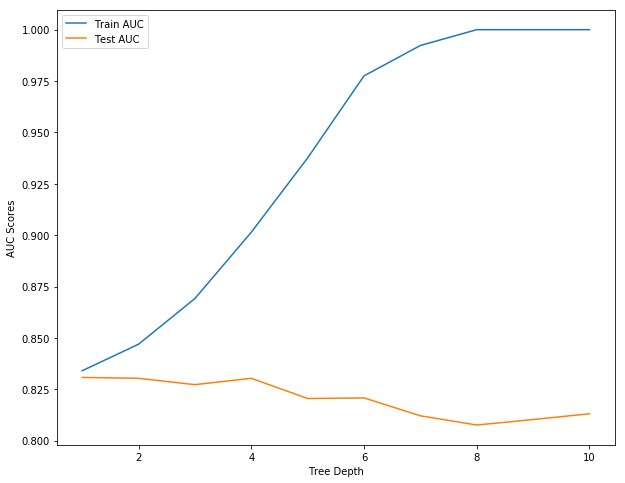

In [185]:
# Visualize effect of different max_depths on AUC scores

max_depths = np.linspace(1,10,10,endpoint=True)
train_auc = []
test_auc = []
count = 0
for depth in max_depths:
    
    clf = GradientBoostingClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = clf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)
    count += 1
    print("Step {} / {}".format(count, len(max_depths)))
plt.figure(figsize=(10,8))
plt.plot(max_depths, train_auc, label='Train AUC')
plt.plot(max_depths, test_auc, label='Test AUC')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

## Gradient Boosted Classifier

In [186]:
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [187]:
y_preds4=grad_clf.predict(X_test)

In [188]:
accuracy_score(y_test, y_preds4)

0.8240837696335078

In [189]:
recall_score(y_test, y_preds4)

0.8741573033707866

              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       510
         1.0       0.78      0.87      0.82       445

   micro avg       0.82      0.82      0.82       955
   macro avg       0.83      0.83      0.82       955
weighted avg       0.83      0.82      0.82       955



Text(33.0, 0.5, 'Actual')

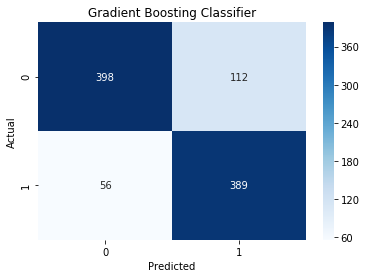

In [191]:
print(classification_report(y_test, y_preds4))
sns.heatmap(confusion_matrix(y_test, y_preds4), annot=True, cmap='Blues', fmt='0.16g')
plt.title('Gradient Boosting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')

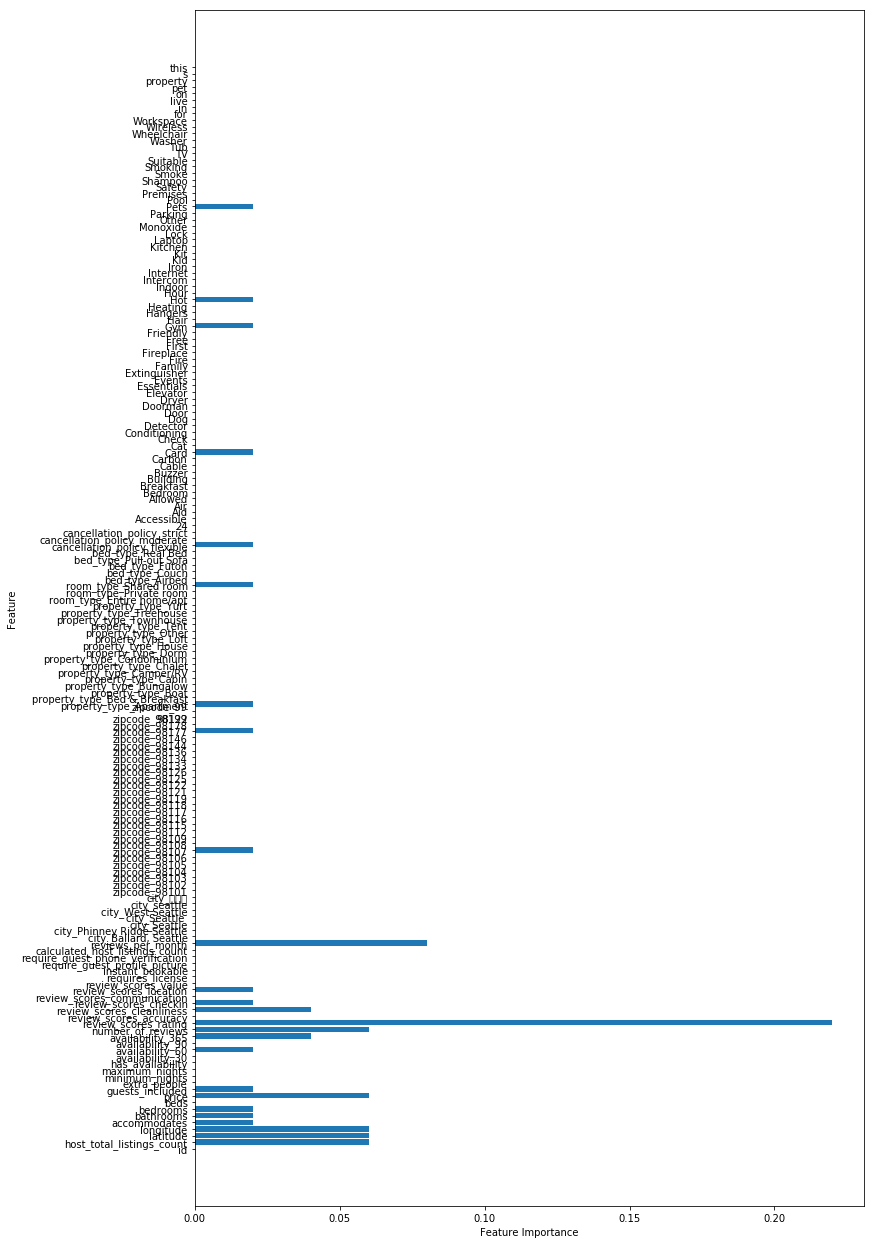

In [192]:
plot_feature_importances(ada_clf, figsize=(12, 22))

Step 1 / 10
Step 2 / 10
Step 3 / 10
Step 4 / 10
Step 5 / 10
Step 6 / 10
Step 7 / 10
Step 8 / 10
Step 9 / 10
Step 10 / 10


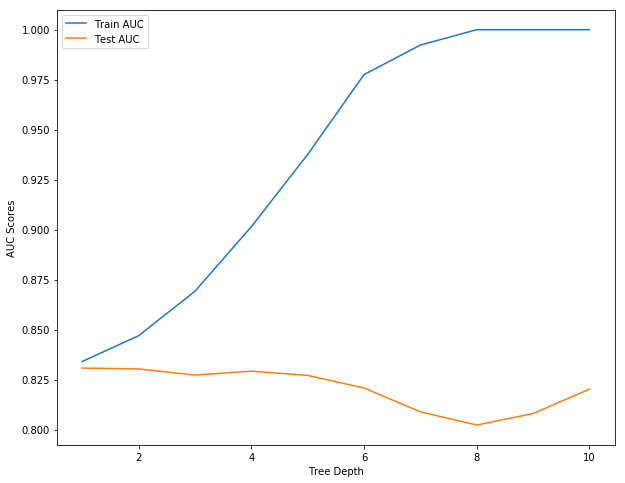

In [193]:
# Visualize effect of different max_depths on AUC scores

max_depths = np.linspace(1,10,10,endpoint=True)
train_auc = []
test_auc = []
count = 0
for depth in max_depths:
    
    clf = GradientBoostingClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    fpr, tpr, thresh = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_auc.append(roc_auc)
    
    test_pred = clf.predict(X_test)
    fpr, tpr, thresh = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_auc.append(roc_auc)
    count += 1
    print("Step {} / {}".format(count, len(max_depths)))
plt.figure(figsize=(10,8))
plt.plot(max_depths, train_auc, label='Train AUC')
plt.plot(max_depths, test_auc, label='Test AUC')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Scores')
plt.legend(loc='best')
plt.show();

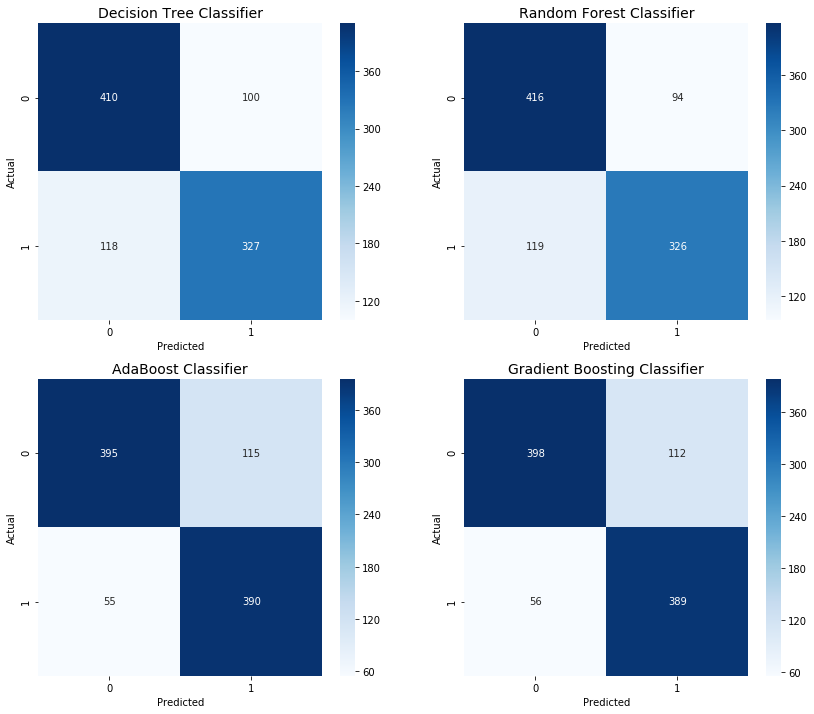

In [194]:
plt.figure(figsize=(14,12))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test, y_preds1), cmap='Blues', annot=True, fmt='0.16g')
plt.title('Decision Tree Classifier', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(222)
sns.heatmap(confusion_matrix(y_test, y_preds2), cmap='Blues', annot=True, fmt='0.16g')
plt.title('Random Forest Classifier', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(223)
sns.heatmap(confusion_matrix(y_test, y_preds3), cmap='Blues', annot=True, fmt='0.16g')
plt.title('AdaBoost Classifier', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(224)
sns.heatmap(confusion_matrix(y_test, y_preds4), cmap='Blues', annot=True, fmt='0.16g')
plt.title('Gradient Boosting Classifier', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Can we Classify to a non-binary target?/

#### What if instead of 0 or 1 for rating above 0.75 and below 0.75, can we classify scores above 0.75, between 0 and 0.75, and scores in the negative?

## Rating > 85                = 2
## 0 < Rating <= 85        = 1
## Rating < 0                  = 0

In [195]:
df1 = pd.read_hdf('seattle_reviews2.h5', key='seattle_reviews2')
df1.head()

,id,review_id,date,reviewer_id,reviewer_name,comments,polarity,latitude,longitude,price,rating,score
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,47.62621,-122.360147,75.0,95.0,75.06
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,47.62621,-122.360147,75.0,95.0,93.78
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,47.62621,-122.360147,75.0,95.0,82.82
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,47.62621,-122.360147,75.0,95.0,78.97
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,47.62621,-122.360147,75.0,95.0,92.94


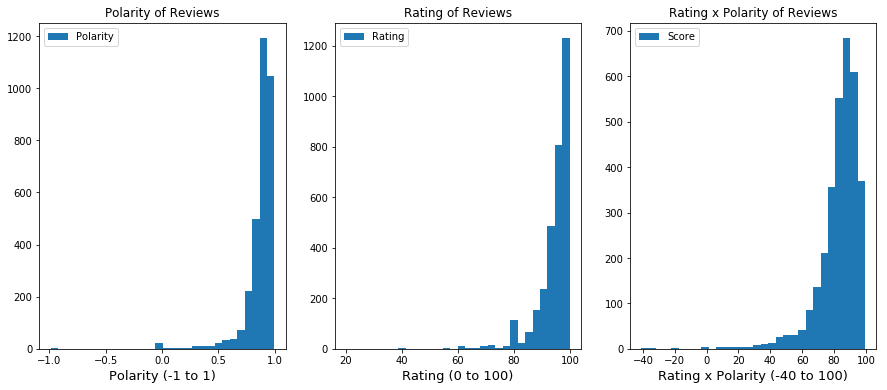

In [196]:
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.hist(df1.groupby('id')['polarity'].mean(), label='Polarity', bins=30)
plt.title('Polarity of Reviews')
plt.xlabel('Polarity (-1 to 1)', fontsize=13)
plt.legend()
plt.subplot(132)
plt.hist(df1.groupby('id')['rating'].mean(), label='Rating', bins=30)
plt.title('Rating of Reviews')
plt.xlabel('Rating (0 to 100)', fontsize=13)
plt.legend()
plt.subplot(133)
plt.hist(df1.groupby('id')['score'].mean(), label='Score', bins=30)
plt.title('Rating x Polarity of Reviews')
plt.xlabel('Rating x Polarity (-40 to 100)', fontsize=13)
plt.legend();

## Run Machine Learning Tests on 3-Class Classification

In [197]:
df = pd.read_hdf('listings_cumulative.h5', key='listings_cumulative')
df.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,Workspace,for,in,live,on,pet,property,s,this,score
0,3335,4.0,47.529846,-122.275840,4,1.0,2.0,2.0,120.0,2,...,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,0.000000
1,4291,6.0,47.687251,-122.313130,2,1.0,1.0,1.0,82.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,71.317714
2,5682,1.0,47.523980,-122.359891,2,1.0,1.0,1.0,48.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,85.204831
3,6606,3.0,47.654109,-122.337605,2,1.0,1.0,1.0,90.0,2,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,85.020577
4,7369,1.0,47.615397,-122.325640,2,1.0,1.0,1.0,85.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,84.982250


In [198]:
df.sort_values(by='score', inplace=True)
df.reset_index(drop=True, inplace=True)

In [199]:
df['score'].describe()

count    3818.000000
mean       69.445612
std        33.149688
min       -40.920000
25%        68.905833
50%        83.807413
75%        90.391856
max        99.650000
Name: score, dtype: float64

In [200]:
df['score'].quantile(1/3), df['score'].quantile(2/3)

(76.61309859154927, 88.26028428428431)

In [201]:
zeros = list(np.linspace(0, 0, 1272))
df[:1272]['score'] = zeros
ones = list(np.linspace(1, 1, 1273))
df[1272:2545]['score'] = ones
twos = list(np.linspace(2, 2, 1273))
df[2545:]['score'] = twos
df['score'].value_counts()

2.0    1273
1.0    1273
0.0    1272
Name: score, dtype: int64

In [202]:
target = df.score
features = df.drop(columns='score')

In [203]:
features.isna().sum().sum()

0

In [204]:
features.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,Wireless,Workspace,for,in,live,on,pet,property,s,this
0,1343805,1.0,47.673304,-122.322513,4,2.0,3.0,1.0,100.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8474294,2.0,47.579529,-122.293866,4,2.0,2.0,1.0,81.0,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7873208,18.0,47.631216,-122.303460,1,3.5,1.0,1.0,29.0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9183838,2.0,47.614205,-122.343989,2,1.0,1.0,1.0,130.0,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7732071,1.0,47.605487,-122.338669,5,2.0,2.0,2.0,129.0,1,...,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0


In [205]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [206]:
df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
df.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,Wireless,Workspace,for,in,live,on,pet,property,s,this
0,-1.419959,-0.215165,1.030116,0.333655,0.329029,1.258055,1.915881,-0.645733,-0.310026,-0.513098,...,-2.885629,-0.499345,-0.241862,-0.647474,-0.554154,-1.168089,-0.116356,-0.554154,-0.487848,-0.554154
1,0.987142,-0.180221,-1.148330,1.236204,0.329029,1.258055,0.783554,-0.645733,-0.520580,1.775462,...,-0.296970,-0.499345,-0.241862,-0.647474,-0.554154,-1.168089,-0.116356,-0.554154,-0.487848,-0.554154
2,0.784228,0.378884,0.052384,0.933922,-1.188160,3.803500,-0.348773,-0.645733,-1.096832,-0.513098,...,-0.296970,-0.499345,-0.241862,-0.647474,-0.554154,0.226895,-0.116356,-0.554154,-0.487848,-0.554154
3,1.226669,-0.180221,-0.342780,-0.342958,-0.682431,-0.438908,-0.348773,-0.645733,0.022428,0.249756,...,-0.296970,-0.499345,-0.241862,-0.647474,-0.554154,-1.168089,-0.116356,-0.554154,-0.487848,-0.554154
4,0.736583,-0.215165,-0.545321,-0.175362,0.834759,1.258055,0.783554,0.231949,0.011346,-0.513098,...,2.291688,-0.499345,-0.241862,1.088521,1.804553,0.226895,-0.116356,1.804553,3.396624,1.804553


In [207]:
X = features
y = target
print(X.shape, y.shape)

(3818, 164) (3818,)


In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

In [209]:
print(X_train.shape, X_test.shape)
print('-'*25)
print(y_train.shape, y_test.shape)

(2863, 164) (955, 164)
-------------------------
(2863,) (955,)


In [210]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [211]:
y_preds = dt_clf.predict(X_test)

In [212]:
accuracy_score(y_test, y_preds)

0.6513089005235602

In [213]:
recall_score(y_test, y_preds, average='weighted')

0.6513089005235602

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       320
         1.0       0.55      0.54      0.55       320
         2.0       0.64      0.66      0.65       315

   micro avg       0.65      0.65      0.65       955
   macro avg       0.65      0.65      0.65       955
weighted avg       0.65      0.65      0.65       955



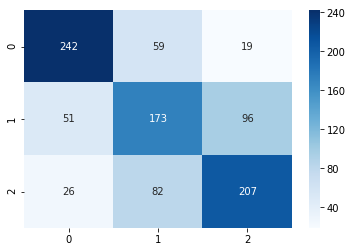

In [214]:
print(classification_report(y_test, y_preds))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='0.16g', cmap='Blues')

In [215]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_preds = rf_clf.predict(X_test)

In [216]:
accuracy_score(y_test, y_preds)

0.6544502617801047

In [217]:
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[248  50  22]
 [ 72 177  71]
 [ 29  86 200]]
              precision    recall  f1-score   support

         0.0       0.71      0.78      0.74       320
         1.0       0.57      0.55      0.56       320
         2.0       0.68      0.63      0.66       315

   micro avg       0.65      0.65      0.65       955
   macro avg       0.65      0.65      0.65       955
weighted avg       0.65      0.65      0.65       955



In [218]:
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train, y_train)
y_preds = ada_clf.predict(X_test)

In [219]:
accuracy_score(y_test, y_preds)

0.6764397905759162

In [220]:
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))

[[249  52  19]
 [ 46 170 104]
 [ 10  78 227]]
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       320
         1.0       0.57      0.53      0.55       320
         2.0       0.65      0.72      0.68       315

   micro avg       0.68      0.68      0.68       955
   macro avg       0.68      0.68      0.68       955
weighted avg       0.68      0.68      0.68       955



In [221]:
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train, y_train)
y_preds = grad_clf.predict(X_test)

In [222]:
accuracy_score(y_test, y_preds)

0.7392670157068063

              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83       320
         1.0       0.66      0.60      0.63       320
         2.0       0.69      0.83      0.76       315

   micro avg       0.74      0.74      0.74       955
   macro avg       0.75      0.74      0.74       955
weighted avg       0.75      0.74      0.74       955



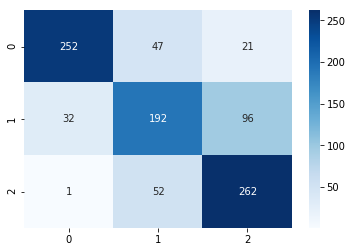

In [223]:
print(classification_report(y_test, y_preds))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='Blues', fmt='0.16g')

In [224]:
df = pd.read_hdf('listings_cumulative.h5', key='listings_cumulative')
df.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,Workspace,for,in,live,on,pet,property,s,this,score
0,3335,4.0,47.529846,-122.275840,4,1.0,2.0,2.0,120.0,2,...,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0,0.000000
1,4291,6.0,47.687251,-122.313130,2,1.0,1.0,1.0,82.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,71.317714
2,5682,1.0,47.523980,-122.359891,2,1.0,1.0,1.0,48.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,85.204831
3,6606,3.0,47.654109,-122.337605,2,1.0,1.0,1.0,90.0,2,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,85.020577
4,7369,1.0,47.615397,-122.325640,2,1.0,1.0,1.0,85.0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,84.982250


In [225]:
drop = list(df.columns[32:-1])
df = df.drop(columns=drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 33 columns):
id                                  3818 non-null int64
host_total_listings_count           3818 non-null float64
latitude                            3818 non-null float64
longitude                           3818 non-null float64
accommodates                        3818 non-null int64
bathrooms                           3818 non-null float64
bedrooms                            3818 non-null float64
beds                                3818 non-null float64
price                               3818 non-null float64
guests_included                     3818 non-null int64
extra_people                        3818 non-null bool
minimum_nights                      3818 non-null int64
maximum_nights                      3818 non-null int64
has_availability                    3818 non-null bool
availability_30                     3818 non-null int64
availability_60                     3818 

In [226]:
target = df['score']
features = df.drop(columns='score')

In [227]:
features.isna().sum().sum()

0

In [228]:
features.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,3335,4.0,47.529846,-122.275840,4,1.0,2.0,2.0,120.0,2,...,10.0,9.0,9.0,9.0,False,False,False,False,4,0.80
1,4291,6.0,47.687251,-122.313130,2,1.0,1.0,1.0,82.0,1,...,10.0,9.0,9.0,9.0,False,False,False,False,5,1.14
2,5682,1.0,47.523980,-122.359891,2,1.0,1.0,1.0,48.0,1,...,10.0,10.0,9.0,10.0,False,True,False,True,1,4.21
3,6606,3.0,47.654109,-122.337605,2,1.0,1.0,1.0,90.0,2,...,10.0,9.0,10.0,9.0,False,False,False,False,1,0.66
4,7369,1.0,47.615397,-122.325640,2,1.0,1.0,1.0,85.0,1,...,10.0,10.0,10.0,9.0,False,False,False,False,1,0.50


In [229]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [230]:
df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
df.head()

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,-1.872473,-0.110333,-2.302505,1.804132,0.329029,-0.438908,0.783554,0.231949,-0.088390,0.249756,...,0.367206,-1.443516,-0.972148,-0.607133,0.0,-0.427951,-0.302974,-0.330025,0.178827,-0.697785
1,-1.872151,-0.040445,1.354127,0.629263,-0.682431,-0.438908,-0.348773,-0.645733,-0.509498,-0.513098,...,0.367206,-1.443516,-0.972148,-0.607133,0.0,-0.427951,-0.302974,-0.330025,0.348541,-0.512139
2,-1.871681,-0.215165,-2.438800,-0.843951,-0.682431,-0.438908,-0.348773,-0.645733,-0.886278,-0.513098,...,0.367206,0.342981,-0.972148,0.738215,0.0,2.336715,-0.302974,3.030072,-0.330316,1.164133
3,-1.871369,-0.145277,0.584203,-0.141838,-0.682431,-0.438908,-0.348773,-0.645733,-0.420844,0.249756,...,0.367206,-1.443516,0.620156,-0.607133,0.0,-0.427951,-0.302974,-0.330025,-0.330316,-0.774227
4,-1.871112,-0.215165,-0.315090,0.235150,-0.682431,-0.438908,-0.348773,-0.645733,-0.476252,-0.513098,...,0.367206,0.342981,0.620156,-0.607133,0.0,-0.427951,-0.302974,-0.330025,-0.330316,-0.861590


In [231]:
X = features
y = target
print(X.shape, y.shape)

(3818, 32) (3818,)


In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

In [233]:
print(X_train.shape, X_test.shape)
print('-'*25)
print(y_train.shape, y_test.shape)

(2863, 32) (955, 32)
-------------------------
(2863,) (955,)


## Decision Tree Regressor to Predict Scores for Airbnb

In [234]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [235]:
y_preds_train = dt_reg.predict(X_train)
y_preds_test = dt_reg.predict(X_test)

train_resids = y_preds_train - y_train
test_resids = y_preds_test - y_test

print("Decision Tree Regression Score (R^2): ", dt_reg.score(X_test, y_test))
print("SciKit-Learn R^2 Score: ", r2_score(y_test, y_preds_test))

Decision Tree Regression Score (R^2):  0.8474949281897537
SciKit-Learn R^2 Score:  0.8474949281897537


In [236]:
train_mse = mean_squared_error(y_train, y_preds_train)
test_mse = mean_squared_error(y_test, y_preds_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 7.78851638800174e-12
Test Mean Squarred Error: 163.19929187726893


In [237]:
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Train RMSE:  2.7907913551538996e-06
Test RMSE:  12.77494782287853


In [238]:
cv_5_results = np.mean(cross_val_score(dt_reg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(dt_reg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(dt_reg, X, y, cv=20, scoring="neg_mean_squared_error"))

print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-159.88607752812655
-183.3900716645971
-138.31969106865446


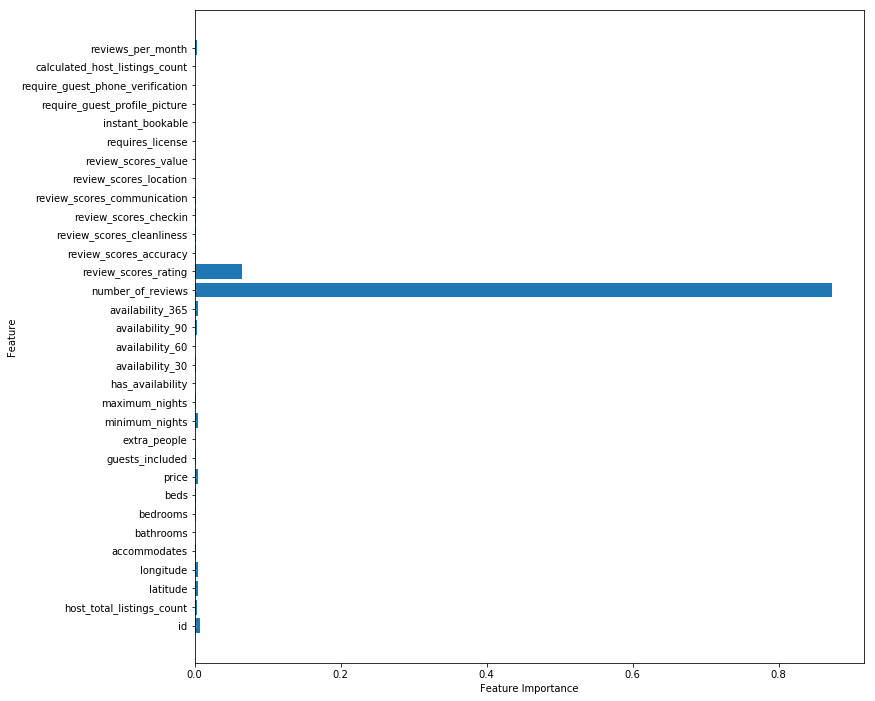

In [239]:
plot_feature_importances(dt_reg, figsize=(12, 12))

## Random Forest Regressor to Predict Scores for Airbnb

In [240]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [241]:
y_preds_train = rf_reg.predict(X_train)
y_preds_test = rf_reg.predict(X_test)

train_resids = y_preds_train - y_train
test_resids = y_preds_test - y_test

print("Random Forest Regression Score (R^2): ", rf_reg.score(X_test, y_test))
print("SciKit-Learn R^2 Score: ", r2_score(y_test, y_preds_test))

Random Forest Regression Score (R^2):  0.9040572506328163
SciKit-Learn R^2 Score:  0.9040572506328163


In [242]:
train_mse = mean_squared_error(y_train, y_preds_train)
test_mse = mean_squared_error(y_test, y_preds_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 13.856231371212106
Test Mean Squarred Error: 102.67061004347977


In [243]:
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Train RMSE:  3.7223959181167317
Test RMSE:  10.132650691871293


In [244]:
cv_5_results = np.mean(cross_val_score(dt_reg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(dt_reg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(dt_reg, X, y, cv=20, scoring="neg_mean_squared_error"))

print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-171.5420666869755
-179.36790109984116
-150.0617358957325


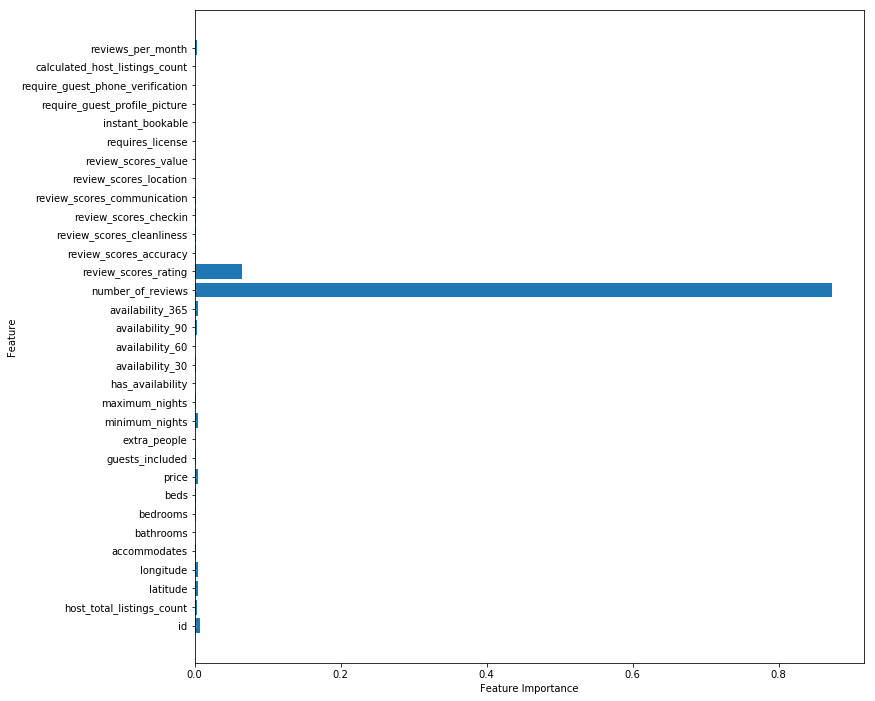

In [245]:
plot_feature_importances(dt_reg, figsize=(12, 12))

## AdaBoost Regressor to Predict Scores for Airbnb

In [246]:
ada_reg = AdaBoostRegressor()
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [247]:
y_preds_train = ada_reg.predict(X_train)
y_preds_test = ada_reg.predict(X_test)

train_resids = y_preds_train - y_train
test_resids = y_preds_test - y_test

print("AdaBoost Regression Score (R^2): ", ada_reg.score(X_test, y_test))
print("SciKit-Learn R^2 Score: ", r2_score(y_test, y_preds_test))

AdaBoost Regression Score (R^2):  0.7204957364681863
SciKit-Learn R^2 Score:  0.7204957364681863


In [248]:
train_mse = mean_squared_error(y_train, y_preds_train)
test_mse = mean_squared_error(y_test, y_preds_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 257.2180396320643
Test Mean Squarred Error: 299.10413695503627


In [249]:
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Train RMSE:  16.038018569388935
Test RMSE:  17.29462740145148


In [250]:
cv_5_results = np.mean(cross_val_score(dt_reg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(dt_reg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(dt_reg, X, y, cv=20, scoring="neg_mean_squared_error"))

print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-164.5436179440713
-168.68364234657543
-154.31337991079403


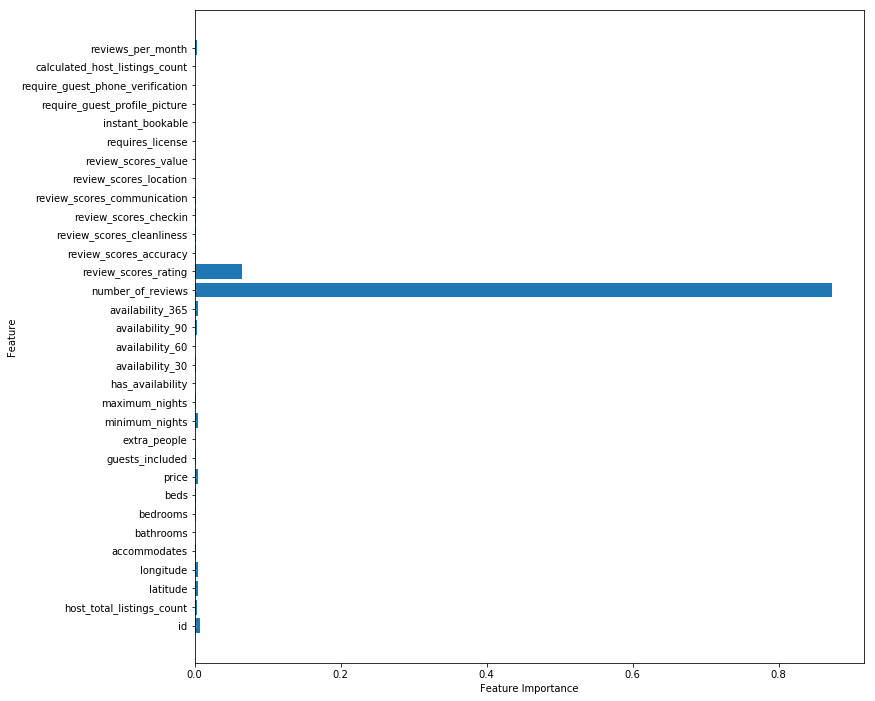

In [251]:
plot_feature_importances(dt_reg, figsize=(12, 12))

## Gradient Boosting Regressor to Predict Scores for Airbnb

In [252]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [253]:
y_preds_train = gb_reg.predict(X_train)
y_preds_test = gb_reg.predict(X_test)

train_resids = y_preds_train - y_train
test_resids = y_preds_test - y_test

print("Gradient Boosting Regression Score (R^2): ", gb_reg.score(X_test, y_test))
print("SciKit-Learn R^2 Score: ", r2_score(y_test, y_preds_test))

Gradient Boosting Regression Score (R^2):  0.916206754082322
SciKit-Learn R^2 Score:  0.916206754082322


In [254]:
train_mse = mean_squared_error(y_train, y_preds_train)
test_mse = mean_squared_error(y_test, y_preds_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 50.266210034156934
Test Mean Squarred Error: 89.66913844595253


In [255]:
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Train RMSE:  7.089866714837235
Test RMSE:  9.469378989456095


In [256]:
cv_5_results = np.mean(cross_val_score(dt_reg, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(dt_reg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(dt_reg, X, y, cv=20, scoring="neg_mean_squared_error"))

print(cv_5_results)
print(cv_10_results)
print(cv_20_results)

-154.39942883702528
-173.12961110748307
-151.7065939948786


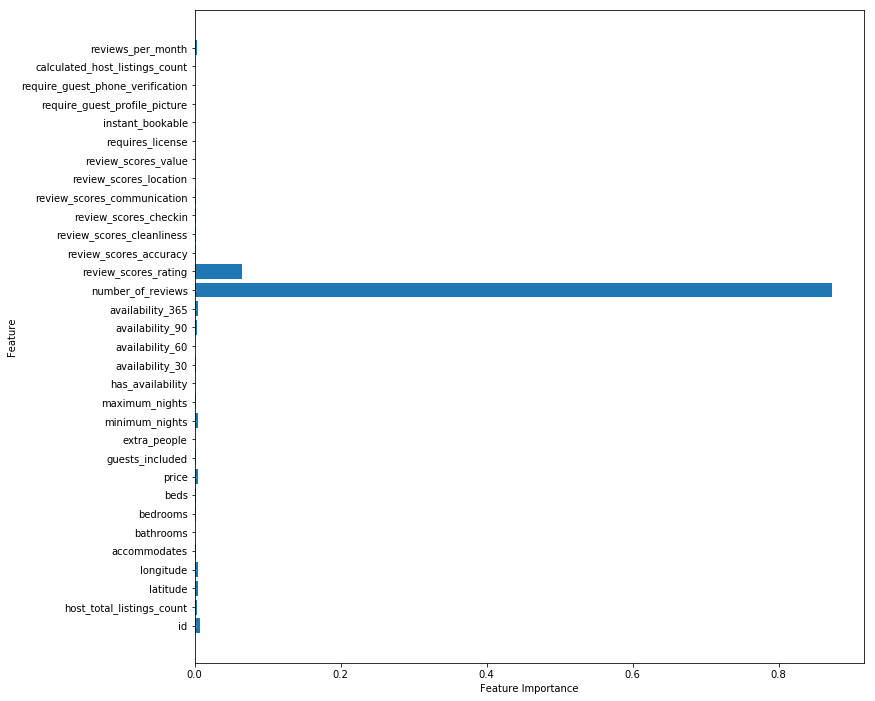

In [257]:
plot_feature_importances(dt_reg, figsize=(12, 12))

In [258]:
X_test.number_of_reviews

3696      0
3644      0
3421      0
2447     18
128      34
3805      0
1565      9
3550      1
179      41
2205      7
328      14
3478      2
2345      4
3777      0
3651      0
51      125
1198     25
2949      3
2238     12
2192      3
1825     13
1890     23
3767      0
1708     26
2927      0
610      67
931      16
314       1
3127      3
3176      1
       ... 
410       2
2721      3
522      49
2394     14
2872      7
725      86
2561      9
556       6
3482      4
72      102
1527     15
574      82
2406     11
1963     11
1567     45
544      47
377      81
2695     16
103      92
276       8
1129      4
3013      1
2703      4
398     106
1095     79
346      23
1367      5
2196      4
47        6
2171     14
Name: number_of_reviews, Length: 955, dtype: int64

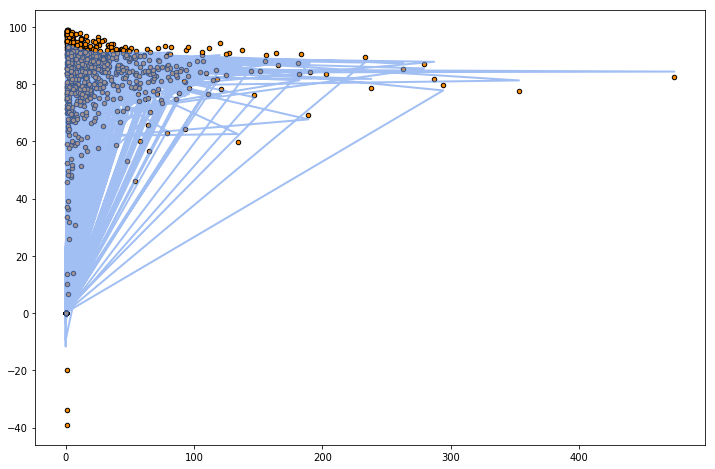

In [259]:
plt.figure(figsize=(12,8))
plt.scatter(X_test.number_of_reviews, y_test, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test.number_of_reviews, y_preds_test, color="cornflowerblue",
         label="max_depth=2", linewidth=2, alpha=0.6)

In [260]:
%notify

<IPython.core.display.Javascript object>